In [1]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import re
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import textwrap
import scipy.stats as stats
import os

from sklearn import svm, datasets
from scipy import stats
from sklearn import neighbors, ensemble, linear_model, neural_network
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import scipy
from functools import partial

import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True})
sns.set_palette(sns.color_palette("Set1", 12))
#sns.set_context("paper")
fontsize = 12
params = {'legend.fontsize': fontsize,
  'figure.figsize': (18, 15),
  'axes.labelsize': fontsize,
  'axes.titlesize':fontsize,
  'axes.edgecolor':"0.3",
  'xtick.labelsize':fontsize,
  'ytick.labelsize':fontsize,
  'legend.fontsize':10,
  'font.size':fontsize,
  'font.family':'serif'}
pylab.rcParams.update(params)
plt.rc('axes', labelsize=fontsize) 

#plt.style.use('ggplot')
%matplotlib inline

import igraph
import cairo
from tqdm.notebook import tqdm
import pandas as pd
from pathlib2 import Path


In [2]:
project_dir = Path('..\..\data\\')
work_dir = project_dir / Path('SST')
trmm_dir = project_dir / Path('TRMM')
era5_dir = project_dir / Path('ERA5')
file_name = 'corr_online_1979_2019_6h_resolution_0.75_window_15d_delay_7d.npy'
data = np.load(work_dir / file_name, mmap_mode = 'r')

In [3]:
result_dir = work_dir / '1979_2019_6h_0.75resolution' / 'result'
result_dir.mkdir(exist_ok=True)

In [4]:
timeseries[0]

NameError: name 'timeseries' is not defined

In [4]:
timeseries = pd.read_csv(work_dir / "1979_2019_6h_0.75resolution" / "times_1979_2019_6h_0.75resolution.txt", header = None)
timeseries = pd.to_datetime(timeseries[0])

In [5]:
timeseries

0       1979-01-01 00:00:00
1       1979-01-01 06:00:00
2       1979-01-01 12:00:00
3       1979-01-01 18:00:00
4       1979-01-02 00:00:00
                ...        
59895   2019-12-30 18:00:00
59896   2019-12-31 00:00:00
59897   2019-12-31 06:00:00
59898   2019-12-31 12:00:00
59899   2019-12-31 18:00:00
Name: 0, Length: 59900, dtype: datetime64[ns]

In [6]:
class DisjointSet:
    '''
     Disjoint Set data structure (Union–Find), is a data structure that keeps track of a 
     set of elements partitioned into a number of disjoint (nonoverlapping) subsets.
     
     Methods:
        find: Determine which subset a particular element is in. Takes an element of any
        subset as an argument and returns a subset that contains our element.
        
        union: Join two subsets into a single subset. Takes two elements of any subsets
        from disjoint_set and returns a disjoint_set with merged subsets.
        
        get: returns current disjoint set.
    '''
    
    def __init__(self, n):
        self.p = -np.ones(n, dtype = np.int32)
        self.cnt = np.ones(n, dtype = np.int32)

    def find_index(self, elem):
        if self.p[elem] == -1:
            return elem
        self.p[elem] = self.find_index(self.p[elem])
        return self.p[elem]

    def find(self, elem):
        return self.find_index(elem)
    
    def get_size(self, elem):
        elem = self.find_index(elem)
        
    
    def union(self, elem1, elem2):
        elem1 = self.find_index(elem1)
        elem2 = self.find_index(elem2)
        if elem1 == elem2:
            return self.cnt[elem1]
        if self.cnt[elem1] < self.cnt[elem2]:
            elem1, elem2 = elem2, elem1
        
        self.cnt[elem1] += self.cnt[elem2]
        self.cnt[elem2] = 0
        self.p[elem2] = elem1
        return self.cnt[elem1]

    def get(self):
        return self.p
    
    def get_sizes(self):
        return self.cnt

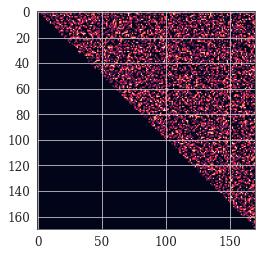

In [7]:
np.random.seed(42)
A = np.random.rand(170, 170)
mask = np.random.randint(2, size = A.shape, dtype = np.bool)
A[mask] = 0
mask_upper = np.tril(np.ones(A.shape, np.bool))
A[mask_upper] = 0
plt.imshow(A)


In [8]:
data.shape

(187, 187, 59900)

In [79]:
def compute_percolation(A, need_extended = False):
    b = A.ravel()
    ravel_sorted_ids = np.argsort(b)
    sorted_ids = np.dstack(np.unravel_index(ravel_sorted_ids, A.shape))
    sorted_ids = sorted_ids[0]
    sorted_ids = sorted_ids[b[ravel_sorted_ids] > 0]
    sorted_ids = sorted_ids[::-1]
    #from disjoint_set import DisjointSet
    dsu = DisjointSet(len(A))
    mx = 1
    delta_max = 0
    delta_max_thr = 1
    if need_extended:
        giant_size = np.zeros(len(sorted_ids))
        thresholds = np.zeros(len(giant_size))
    for i, (x, y) in enumerate(sorted_ids):
        cnt = dsu.union(x, y)
        mx_prev = mx
        mx = max(mx, cnt)
        delta = mx - mx_prev
        thr = A[x, y]
        if delta_max < delta:
            delta_max = delta
            delta_max_thr = thr
            delta_max_id = i
        if need_extended:
            thresholds[i] = thr
            giant_size[i] = mx
    
    if need_extended:
        dsu = DisjointSet(len(A))
        for i, (x, y) in enumerate(sorted_ids):
            if i == delta_max_id:
                break
            cnt = dsu.union(x, y)
        colors = np.zeros((len(A), ), np.int32)
        for i in range(len(A)):
            colors[i] = dsu.find_index(i)
        _, colors = np.unique(colors, return_inverse = True)
    if need_extended:
        return delta_max, delta_max_thr, thresholds, giant_size, colors
    else:
        return delta_max, delta_max_thr


In [71]:
_, ids = np.unique([[17, 0, 0, 18, 17, 3, 18, 18], [1, 2, 3]], return_inverse = True)
print(ids)

[1 0]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [26]:
timeseries[59700]

Timestamp('2019-11-12 00:00:00')

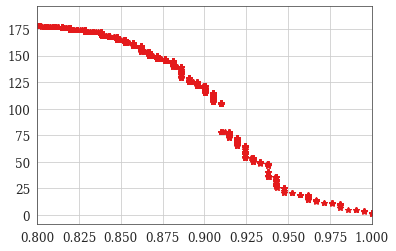

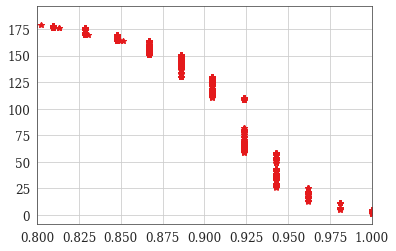

In [80]:
for t in range(59683, 59685):
    delta_max, delta_max_thr, thresholds, giant_size, colors = compute_percolation(data[:, :, t], True)
    plt.figure()
    plt.plot(thresholds, giant_size, '*')
    plt.xlim([0.8, 1])

In [42]:
file_name = work_dir / "1979_2019_6h_0.75resolution" / 'lat_1979_2019_6h_0.75resolution.csv'
lat = pd.read_csv(file_name, header = None)
lat = np.array(lat)[0]
file_name = work_dir / "1979_2019_6h_0.75resolution" / 'lon_1979_2019_6h_0.75resolution.csv'
lon = pd.read_csv(file_name, header = None)
lon = np.array(lon)[0]

file_name = work_dir / "1979_2019_6h_0.75resolution" / 'resulting_cube_1979_2019_6h_0.75resolution.npz'
data_t = np.load(work_dir / file_name)
data_s = data_t['arr_0'].transpose((1, 2, 0))
bad_mask = np.any(np.isnan(data_s), axis = 2)

n, m, nt = data_s.shape

In [43]:
len(lat), len(lon), data_s.shape

(15, 39, (15, 39, 59900))

In [117]:
def make_colors_n(colors, n = 5):
    vals, rev, cnt = np.unique(colors, return_counts=True, return_inverse = True)
    ids = np.argsort(cnt)
    ids = vals[ids]
    colors2 = colors.copy()
    colors2[:] = 0
    for i, cid in enumerate(ids[-5:]):
        colors2[colors == cid] = i + 1
    return colors2

def make_colors2d(lon, lat, colors2):
    colors2d = -np.ones((len(lat), len(lon)), np.int32)
    k = 0
    for i in range(n):
        for j in range(m):
            if ~bad_mask[i, j]:
                colors2d[i, j] = colors2[k]
                k += 1
    xv, yv = np.meshgrid(lon, lat, sparse=False, indexing='ij')
    return xv, yv, colors2d



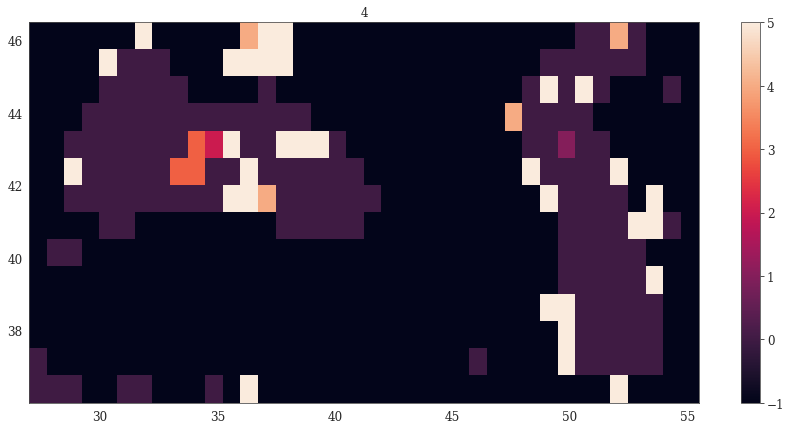

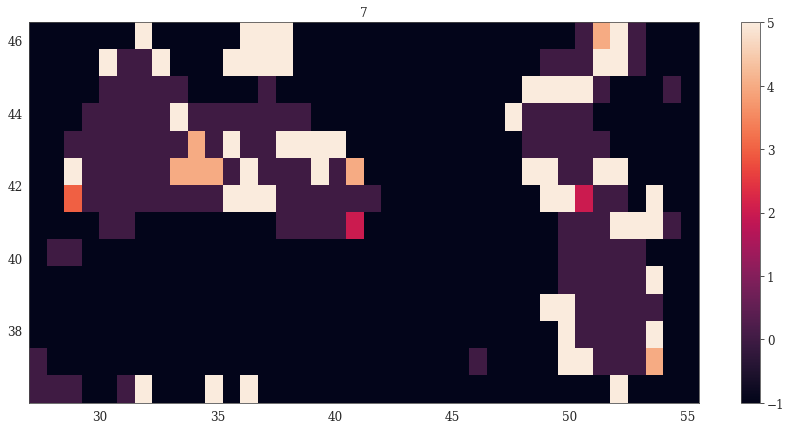

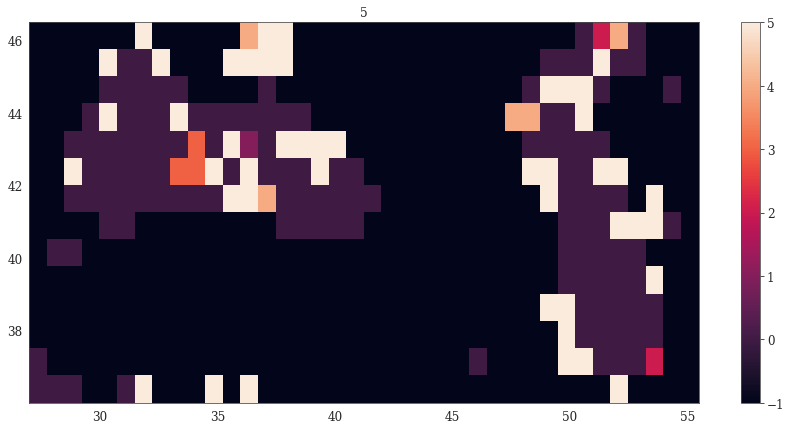

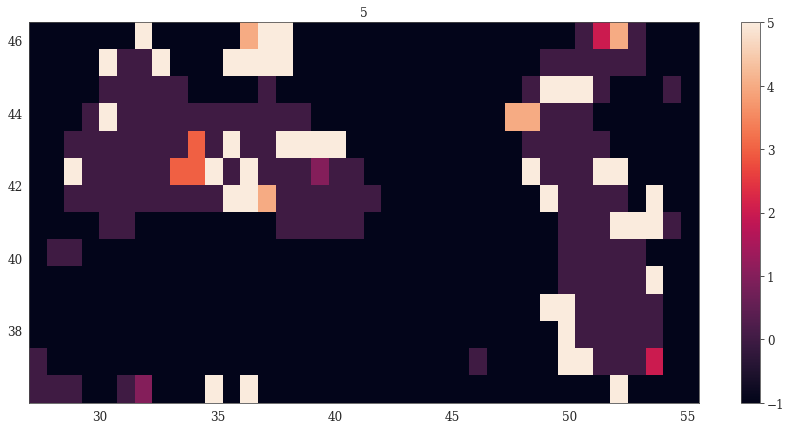

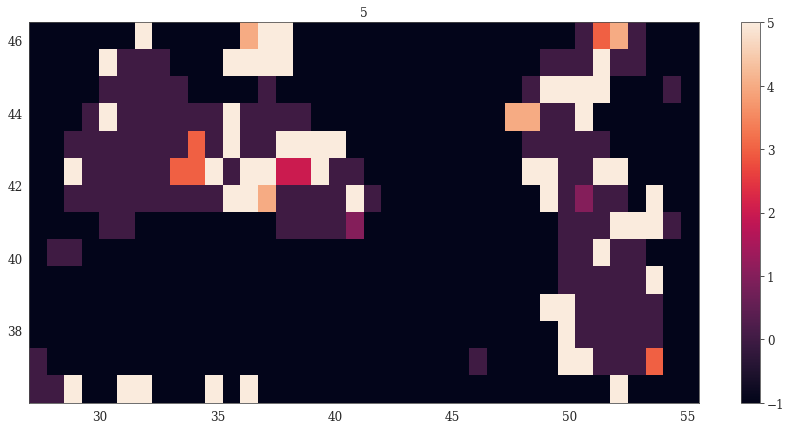

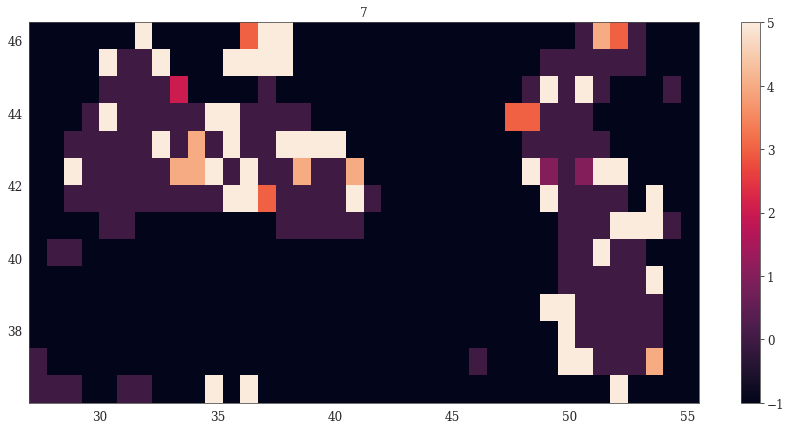

In [277]:
# 59683
#for t in range(59683, 59689):
for t in range(59783, 59789):
#for t in range(nt - 660, nt - 650):
    delta_max, delta_max_thr, thresholds, giant_size, colors = compute_percolation(data[:, :, t], True)
    colors2 = make_colors_n(colors)
    xv, yv, colors2d = make_colors2d(lon, lat, colors2)

    plt.figure(figsize = (15, 7))
    plt.title(delta_max)
    plt.pcolor(xv, yv, colors2d.T)
    plt.colorbar()

(15, 39)

In [20]:
delta_max_thr, delta_max

(0.9238095238095239, 26)

In [194]:
from time import time
be = time()
nt = data.shape[2]
delta_max_all = np.zeros(nt, dtype = np.int32)
delta_max_thr_all = np.zeros(nt, dtype = np.float32)
for t in tqdm(range(nt)):
    cur = np.array(data[:, :, t])
    delta_max_all[t], delta_max_thr_all[t] = compute_percolation(cur)
en = time()

In [23]:
result_dir

WindowsPath('../../data/SST/1979_2019_6h_0.75resolution/result')

In [195]:
df_delta_max = pd.DataFrame({'datetime': timeseries, 'delta_max': delta_max_all, 'delta_max_thr_all': delta_max_thr_all})
df_delta_max.to_csv(result_dir / 'delta_max.tsv', sep = '\t')
np.savez(result_dir / 'delta_max.npz', delta_max_all = delta_max_all, timeseries = timeseries, delta_max_thr_all = delta_max_thr_all)

In [196]:
data = np.load(result_dir / 'delta_max.npz')
delta_max_all = data['delta_max_all']
delta_max_thr_all = data['delta_max_thr_all']

(59900,)

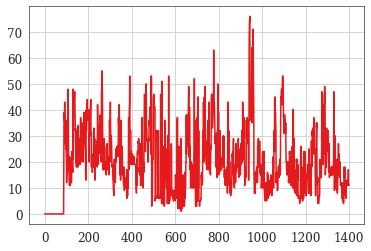

In [81]:
plt.plot(delta_max[:1400])

# Analyze correlation between component size percolation and TRMM

In [201]:
file_name = trmm_dir / "TRMM_prc_1998_2019_6h_0.25" / "number_extreme_points(t)_99percentile_1998_2019_6h_0.25.npz"
data = np.load(file_name)
TRMM_count = data['arr_0']
delta_max_all_short = delta_max_all[-len(TRMM_count):]
delta_max_thr_all_short = delta_max_thr_all[-len(TRMM_count):]

file_name = trmm_dir / "TRMM_prc_1998_2019_6h_0.25" / "times_1998_2019_6h.txt"
timeseries_TRMM = pd.read_csv(file_name, header = None)
timeseries_TRMM = pd.to_datetime(timeseries_TRMM[0])

In [181]:
TRMM_count.shape, delta_max_all_short.shape, type(timeseries_TRMM), type(timeseries)

((32140,), (32140,), pandas.core.series.Series, pandas.core.series.Series)

array([[1.        , 0.03396616],
       [0.03396616, 1.        ]])

[[1.         0.03484184]
 [0.03484184 1.        ]]
0.49543378995433796


Text(0, 0.5, 'TRMM count')

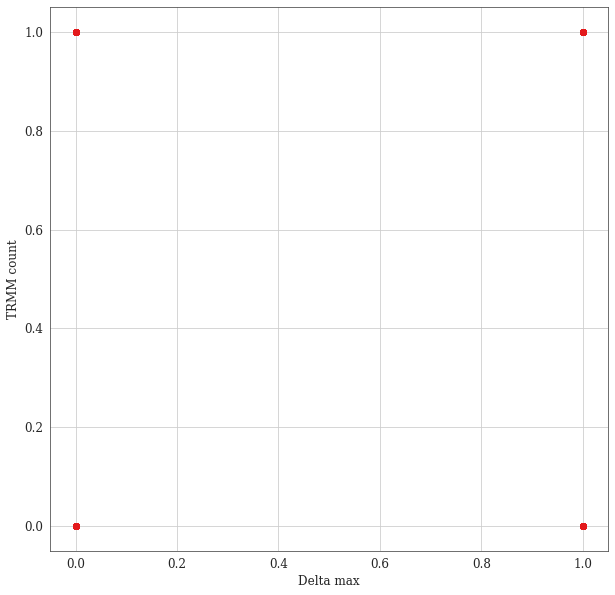

In [272]:
january = get_month_mask(timeseries_TRMM, 1)
#TRMM_count_high = TRMM_count.copy()
TRMM_count_high = TRMM_count > 0
delta_max_all_short_high = delta_max_all_short > 10
print(np.corrcoef(TRMM_count_high[january], delta_max_all_short_high[january]))
from sklearn.metrics import accuracy_score, zero_one_loss, jaccard_score,hamming_loss,f1_score,precision_score
print(f1_score(TRMM_count_high[january], delta_max_all_short_high[january]))
plt.figure(figsize = (10, 10))
plt.scatter(delta_max_all_short_high[january], TRMM_count_high[january], alpha = 0.5)
plt.xlabel('Delta max')
plt.ylabel('TRMM count')

In [116]:
len(timeseries) / window

41.02739726027397

In [190]:
delta_max_thr_all[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

0        False
1        False
2        False
3        False
4        False
         ...  
59895    False
59896    False
59897    False
59898    False
59899    False
Name: 0, Length: 59900, dtype: bool

In [209]:
def plot_delta_max(timeseries, delta_max, mask):
    ts = timeseries[mask]
    plt.plot(ts, delta_max[mask], 'b', linewidth = 1)
    plt.plot(ts, np.ones(np.sum(mask)) * 50, 'r--', linewidth = 1)
    plt.ylim([0, 100])
    plt.xlim([ts.values[0], ts.values[-1]])
    plt.xlabel('Time')
    plt.ylabel('Max giant component size abrupt')
    
def plot_TRMM(timeseries, TRMM_count, mask):
    ts = timeseries[mask]
    plt.plot(ts, TRMM_count[mask], 'r', linewidth = 1)
    plt.ylim([0, 100])
    plt.ylabel('TRMM')
    
def plot_threshold(timeseries, thresholds, mask):
    ts = timeseries[mask]
    plt.plot(ts, thresholds[mask], 'g', linewidth = 1)
    plt.ylim([0, 1])
    plt.ylabel('Threshold')
    
def get_year_mask(timeseries, year):
    mask = (timeseries >= str(year) + '-1-1') & (timeseries < str(year + 1) + '-1-1')
    return mask

def get_month_mask(timeseries, month):
    #mask = np.zeros(len(timeseries), np.bool)
    mask = timeseries.dt.month == month
    #for i, t in enumerate(timeseries):
    #    mask[i] = t.dt.month == 1
    #    mask = (timeseries >= str(year) + '-1-1') & (timeseries < str(year + 1) + '-1-1')
    return mask

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


NameError: name 'sdf' is not defined

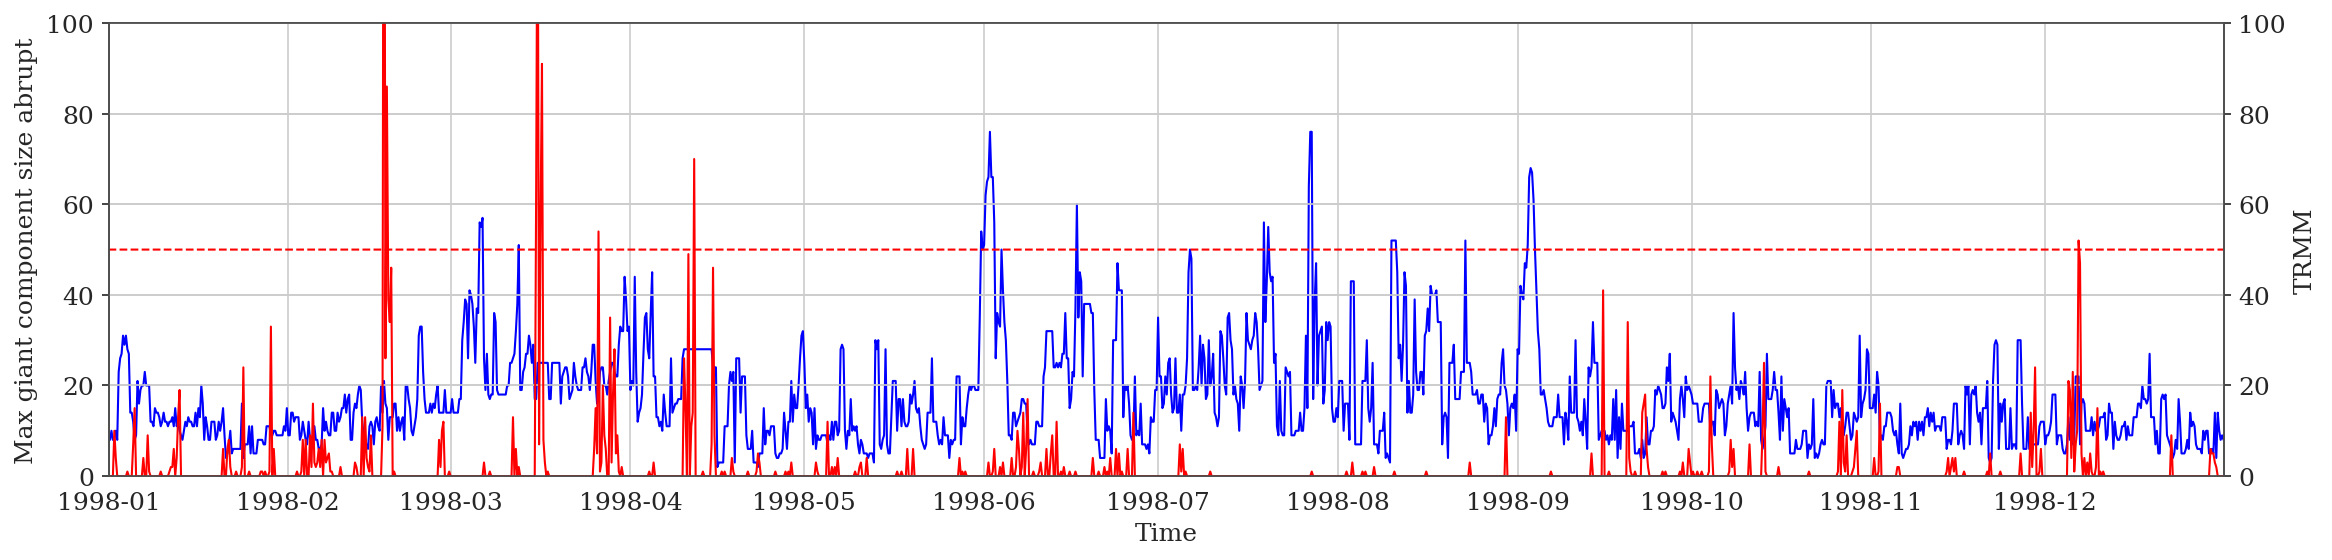

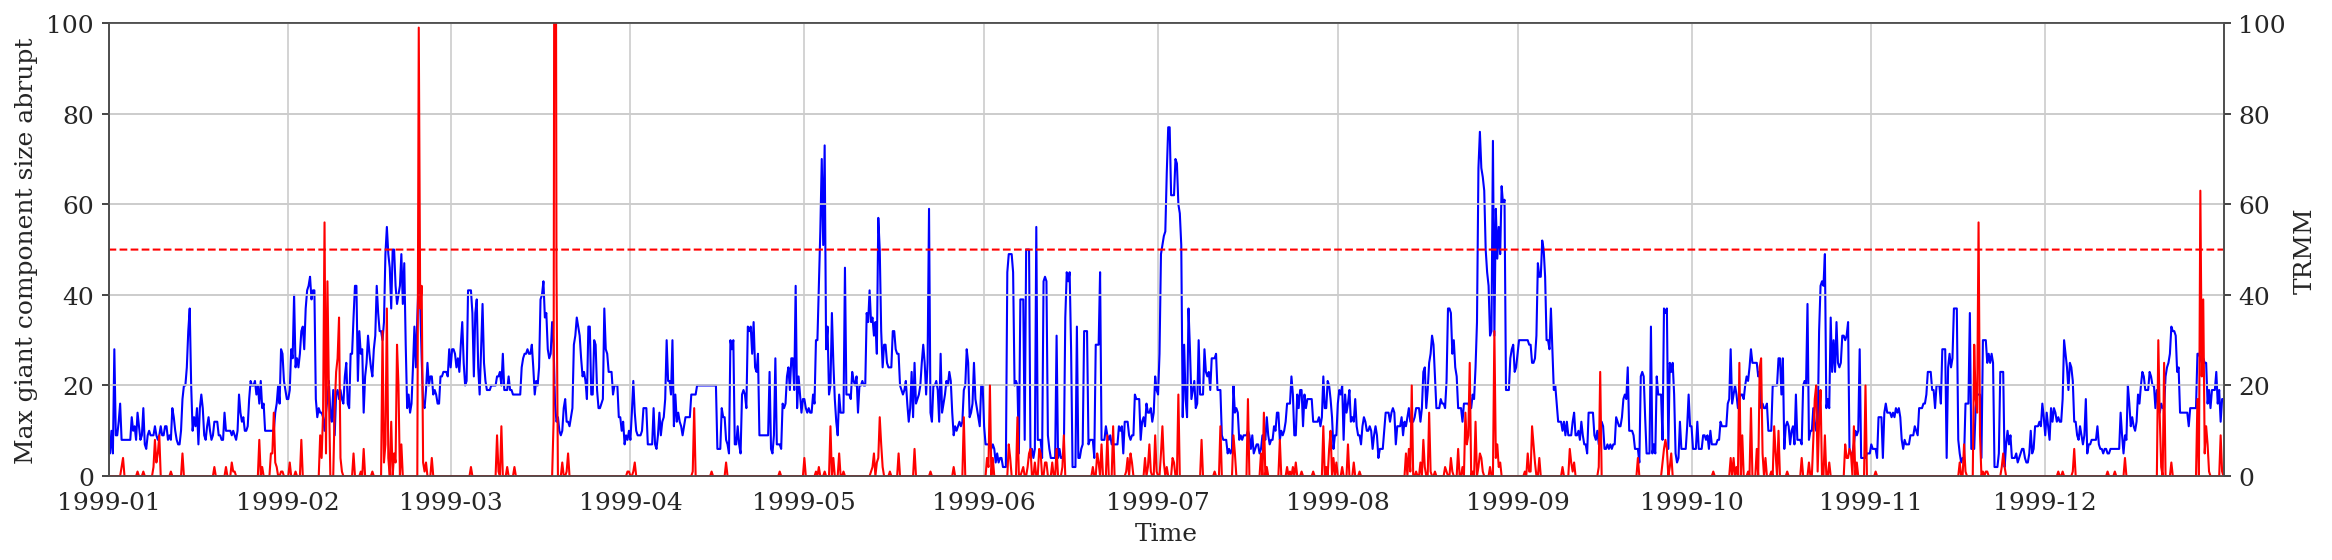

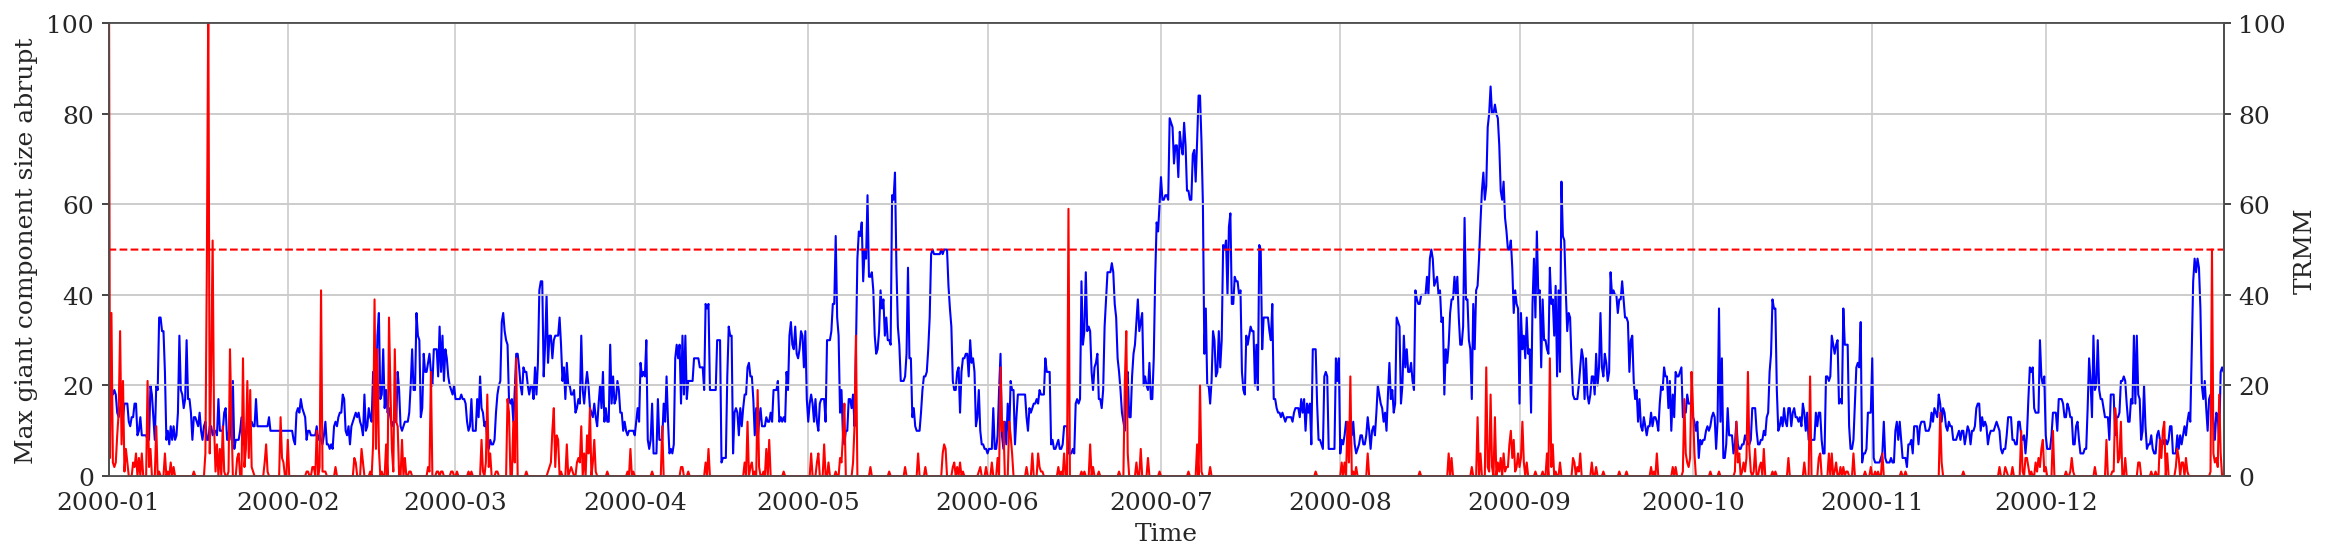

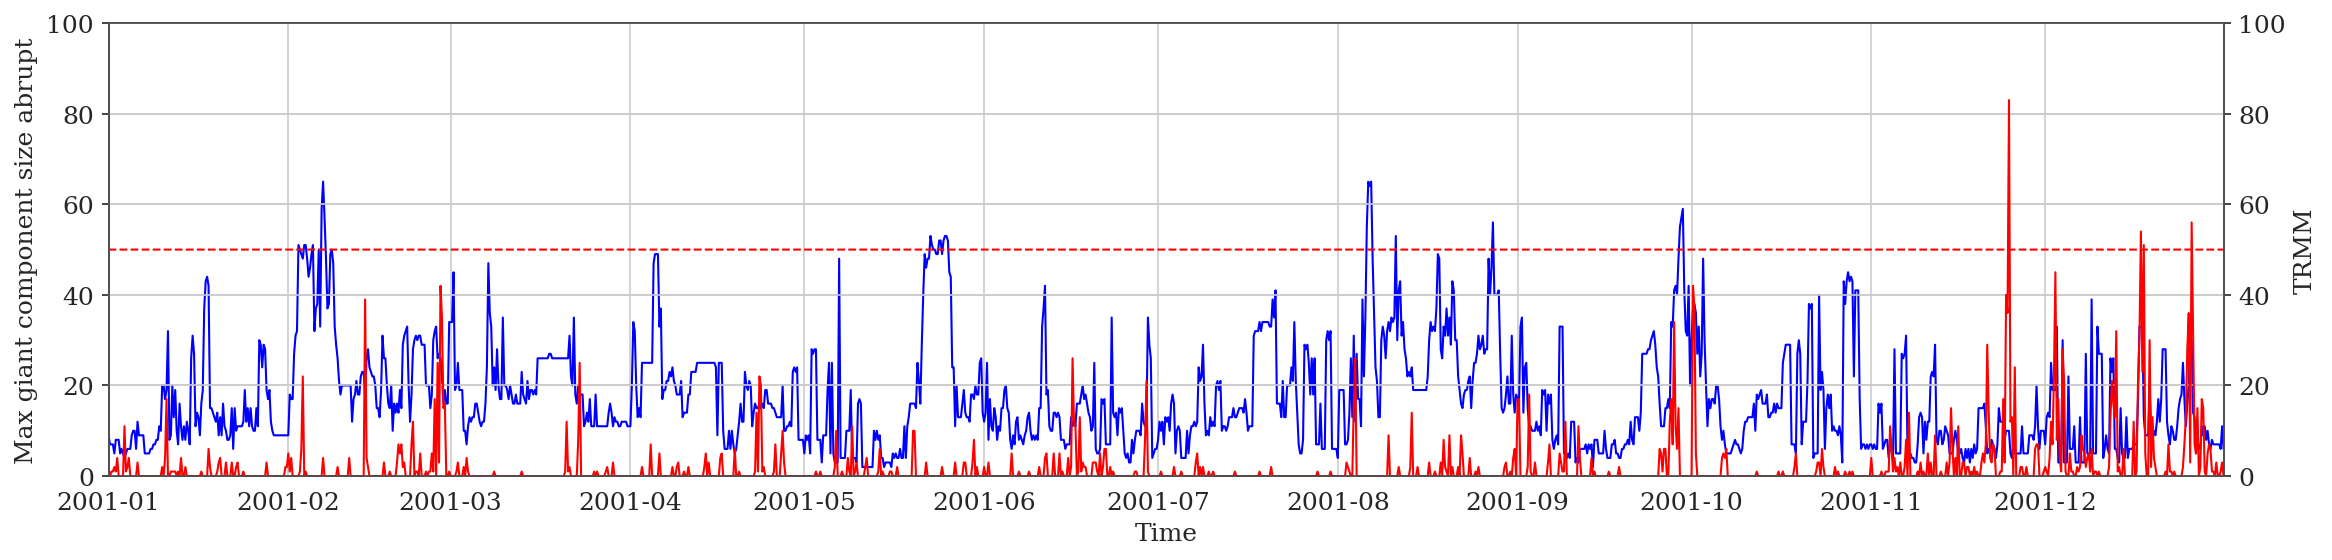

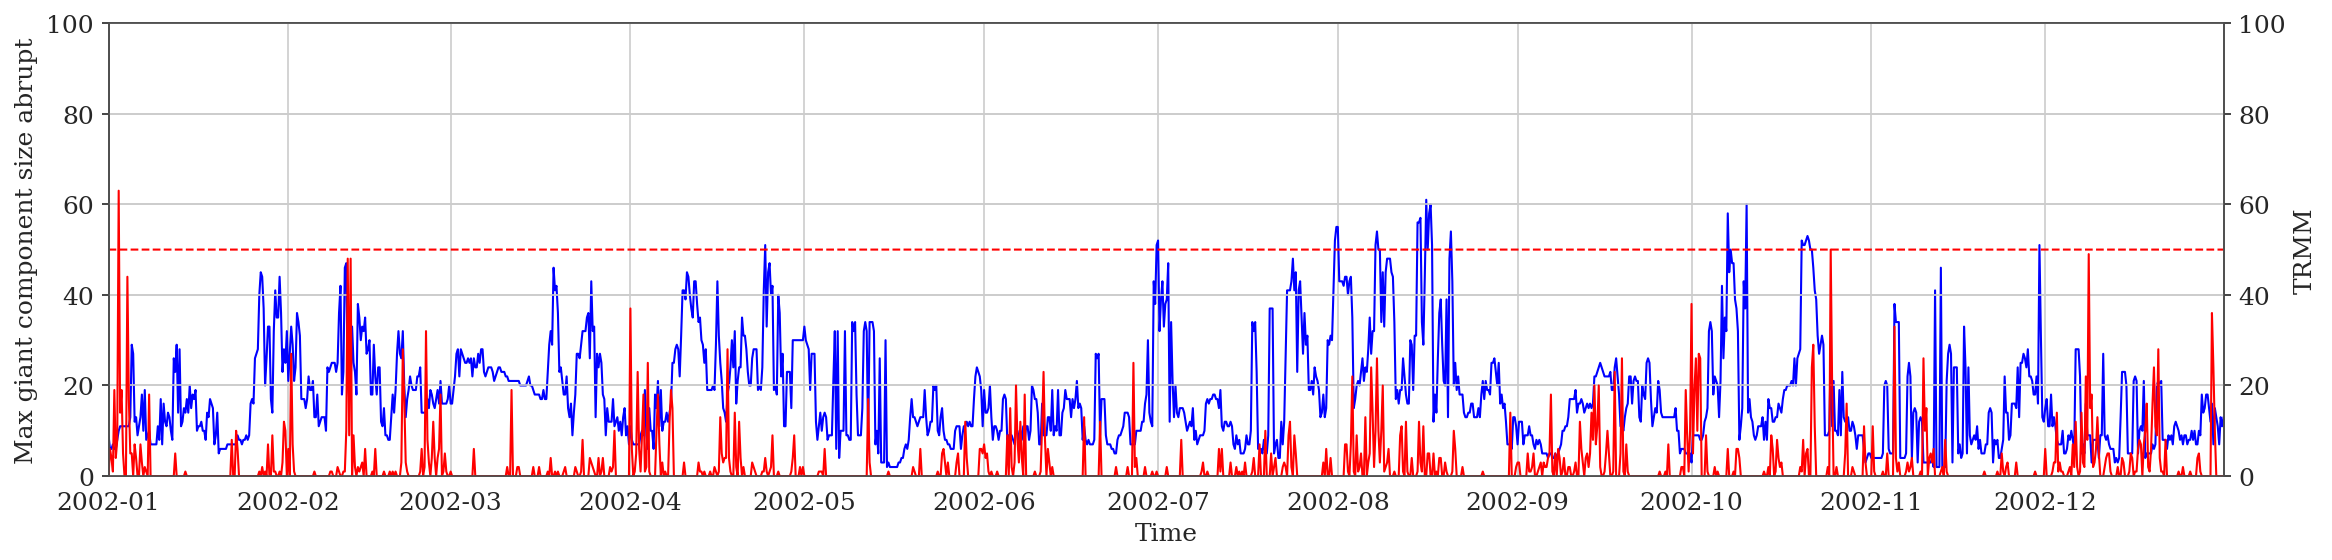

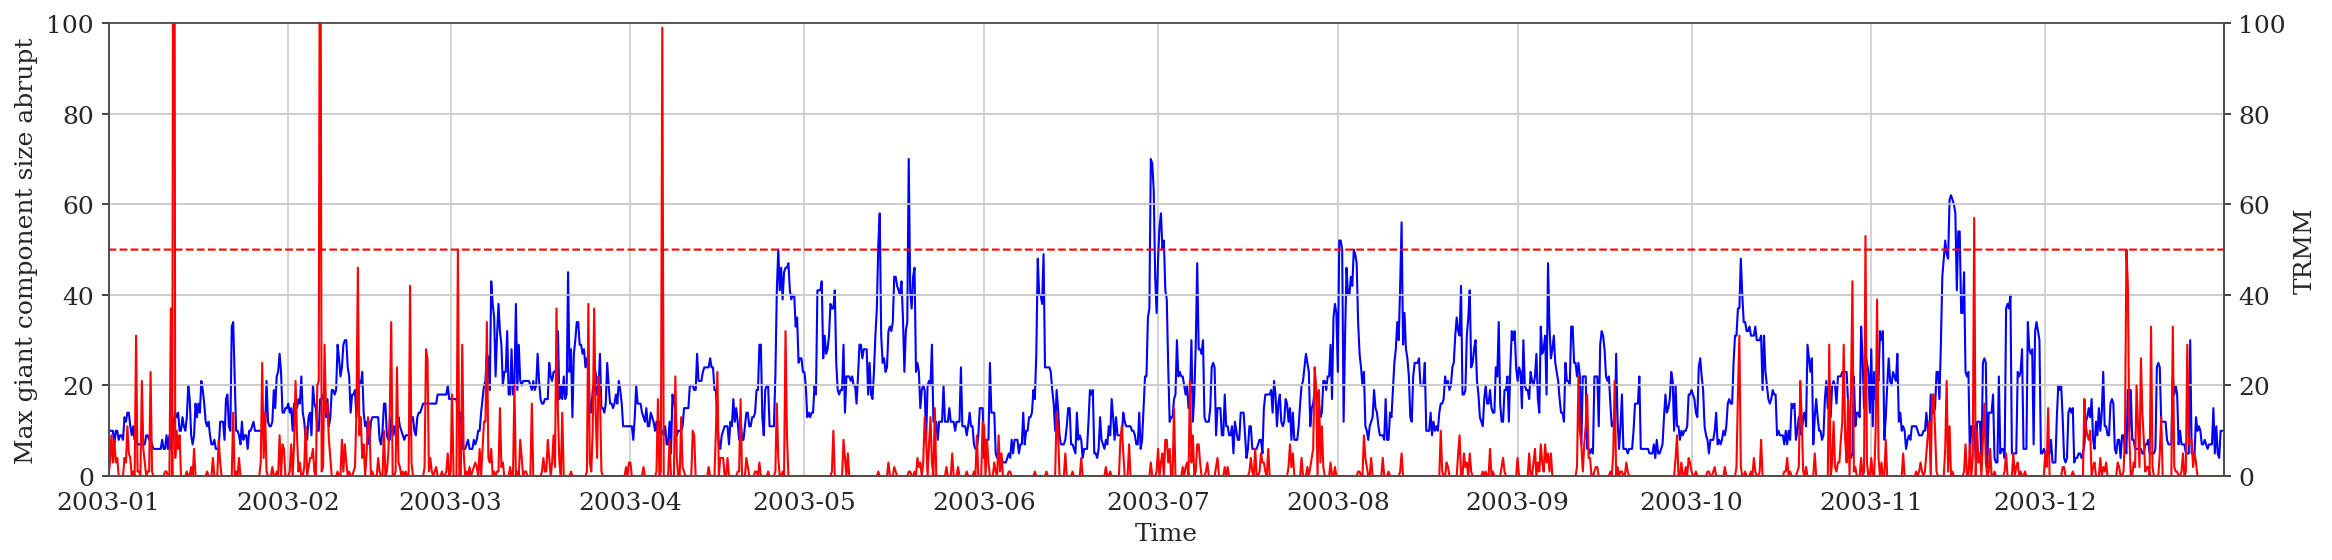

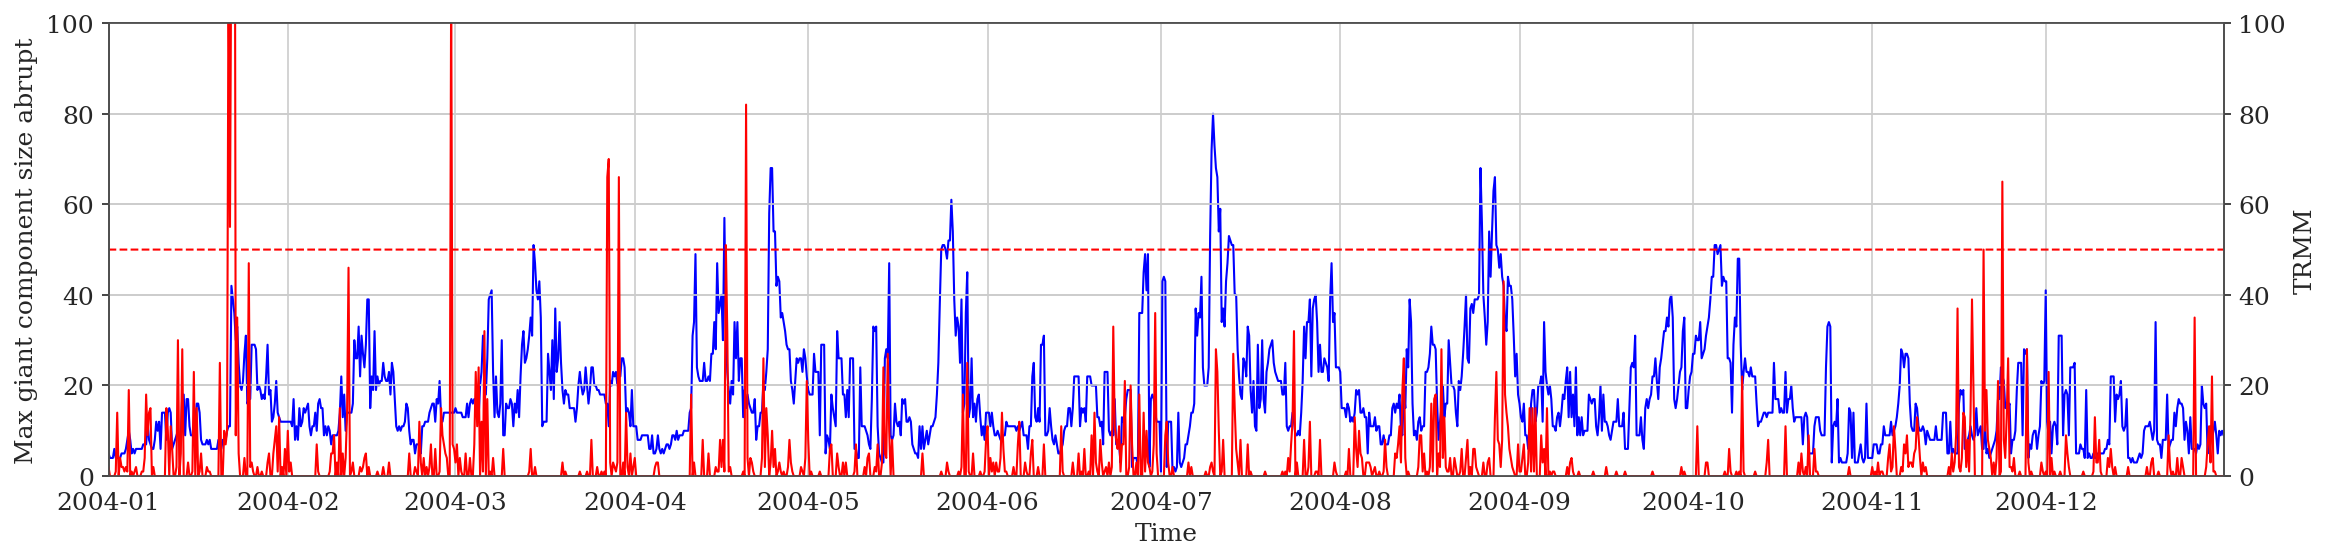

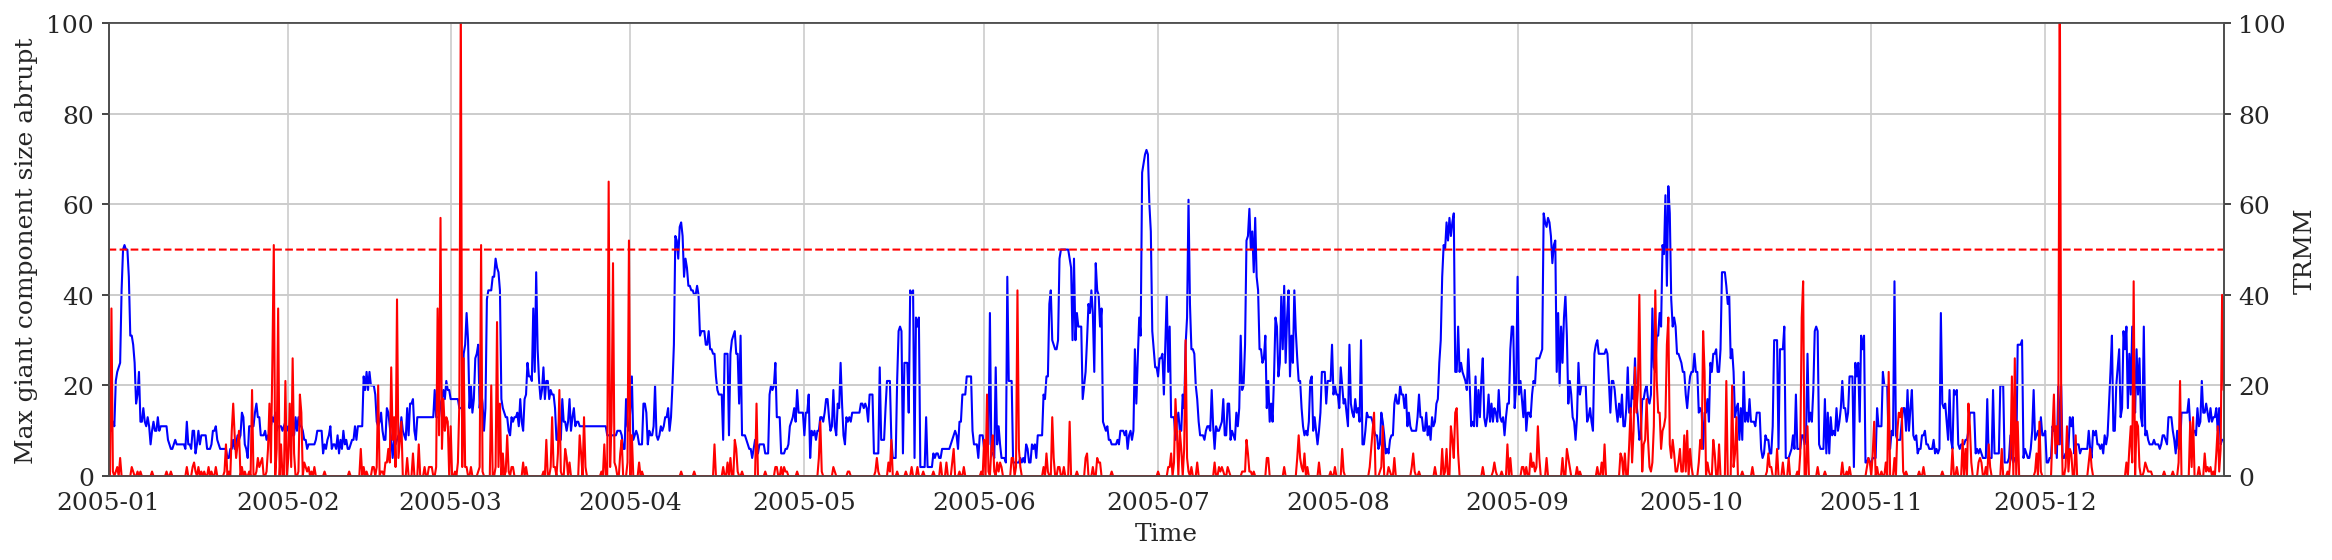

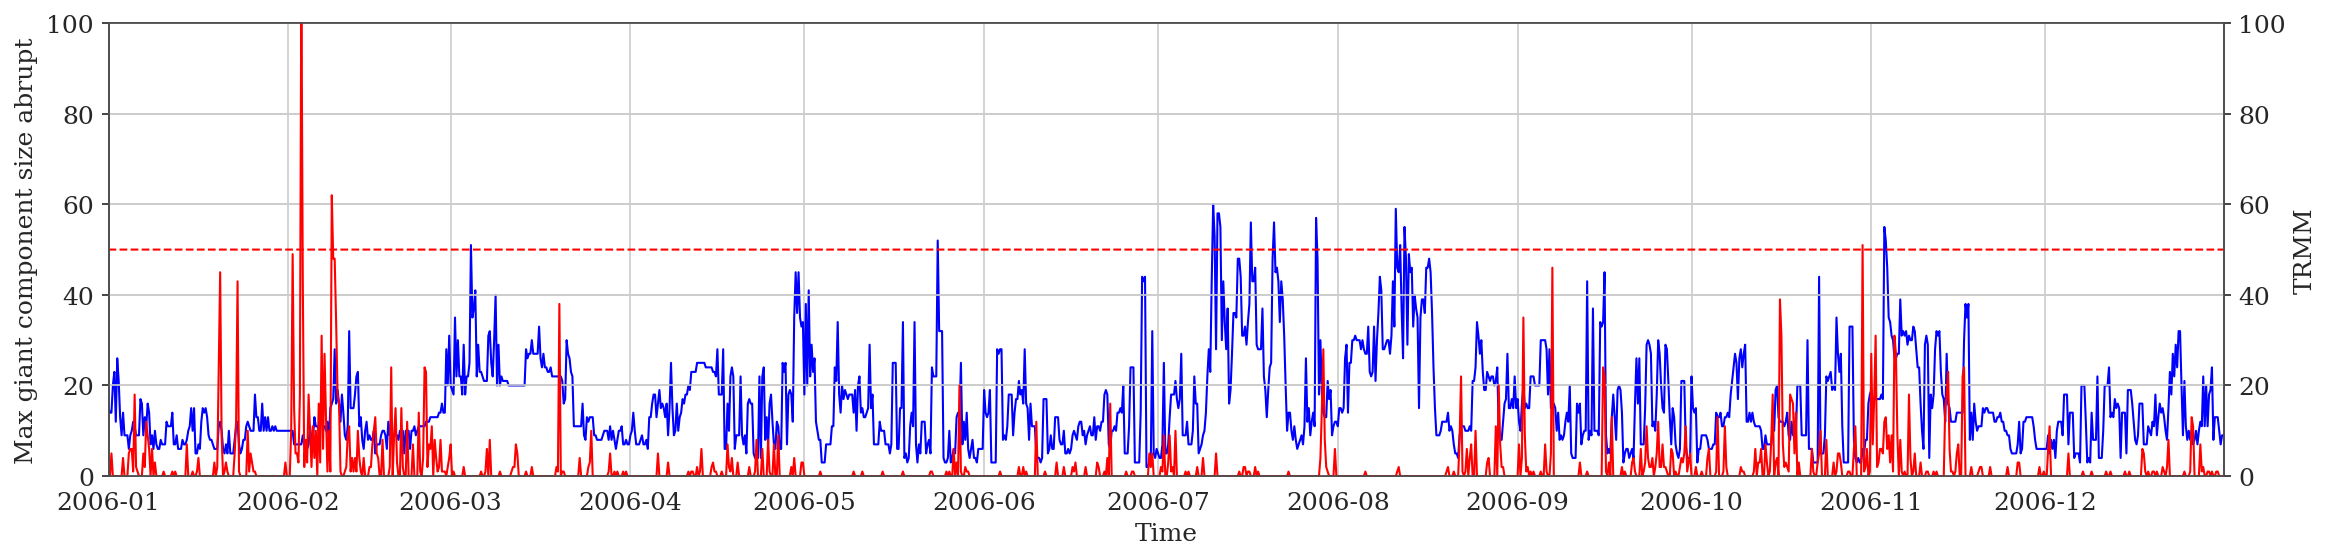

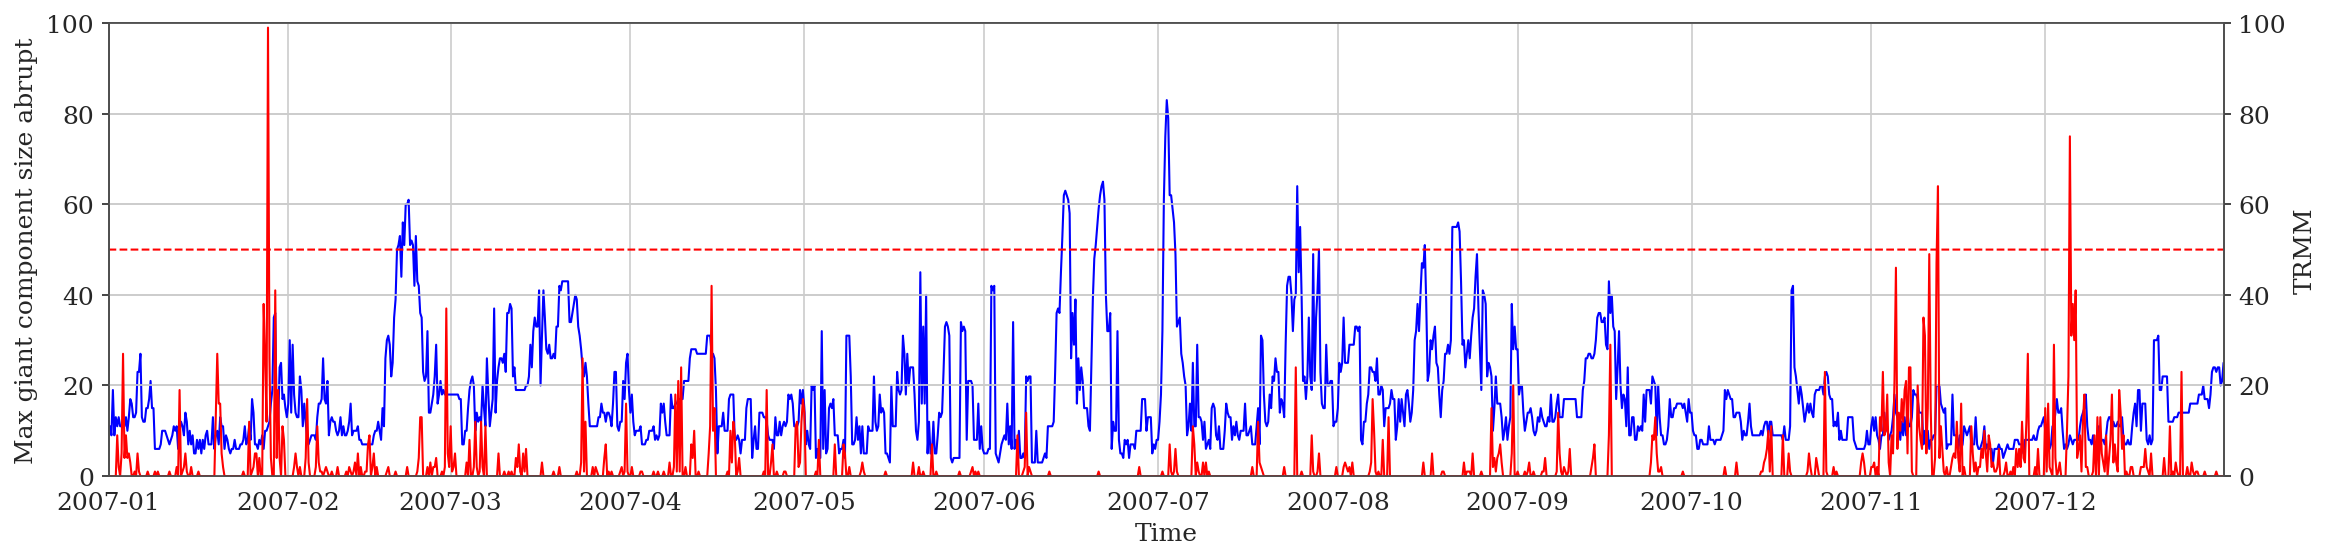

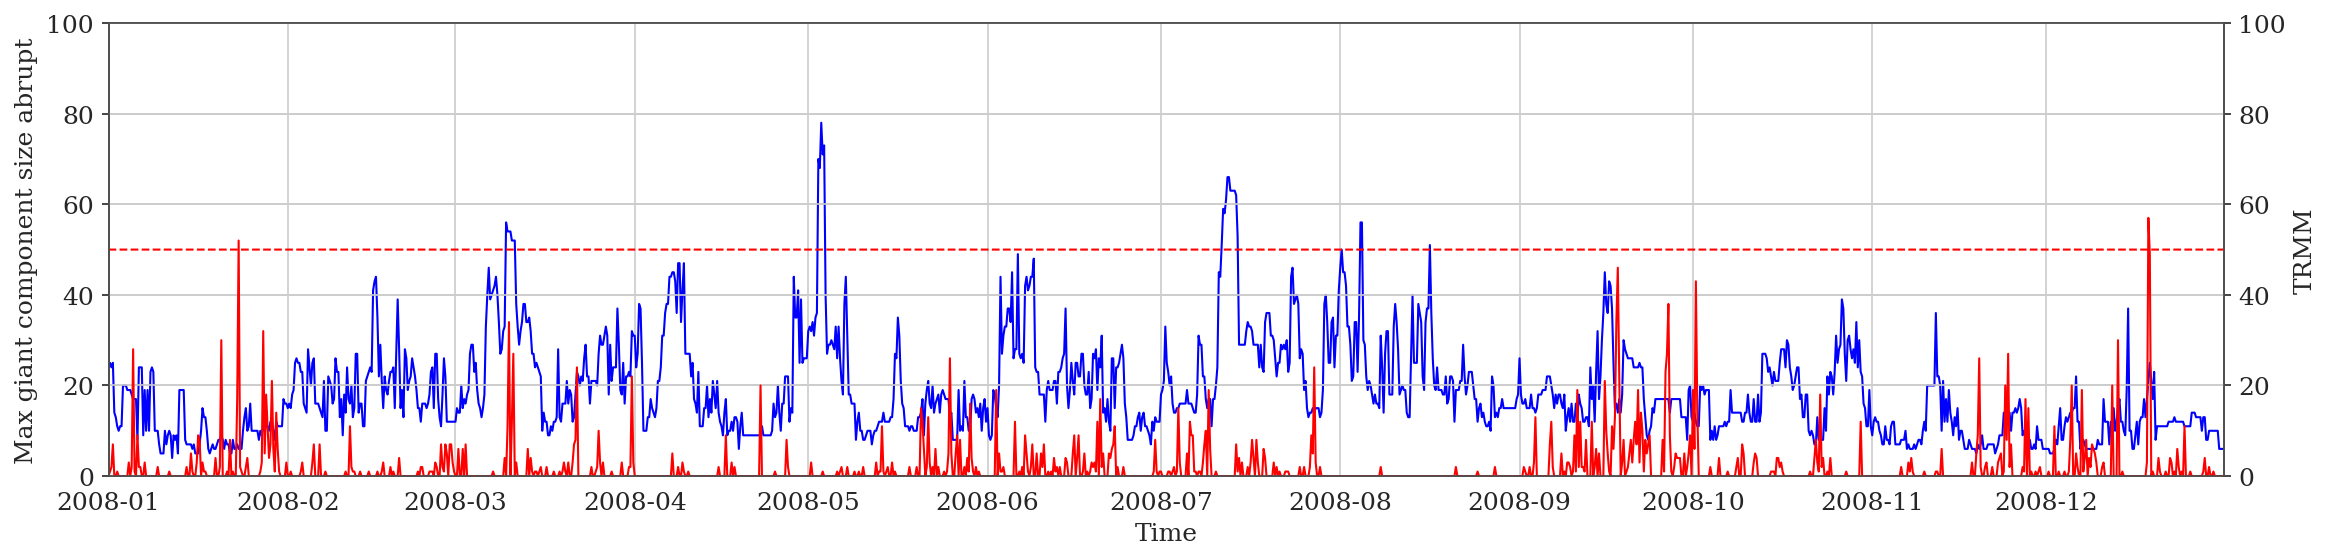

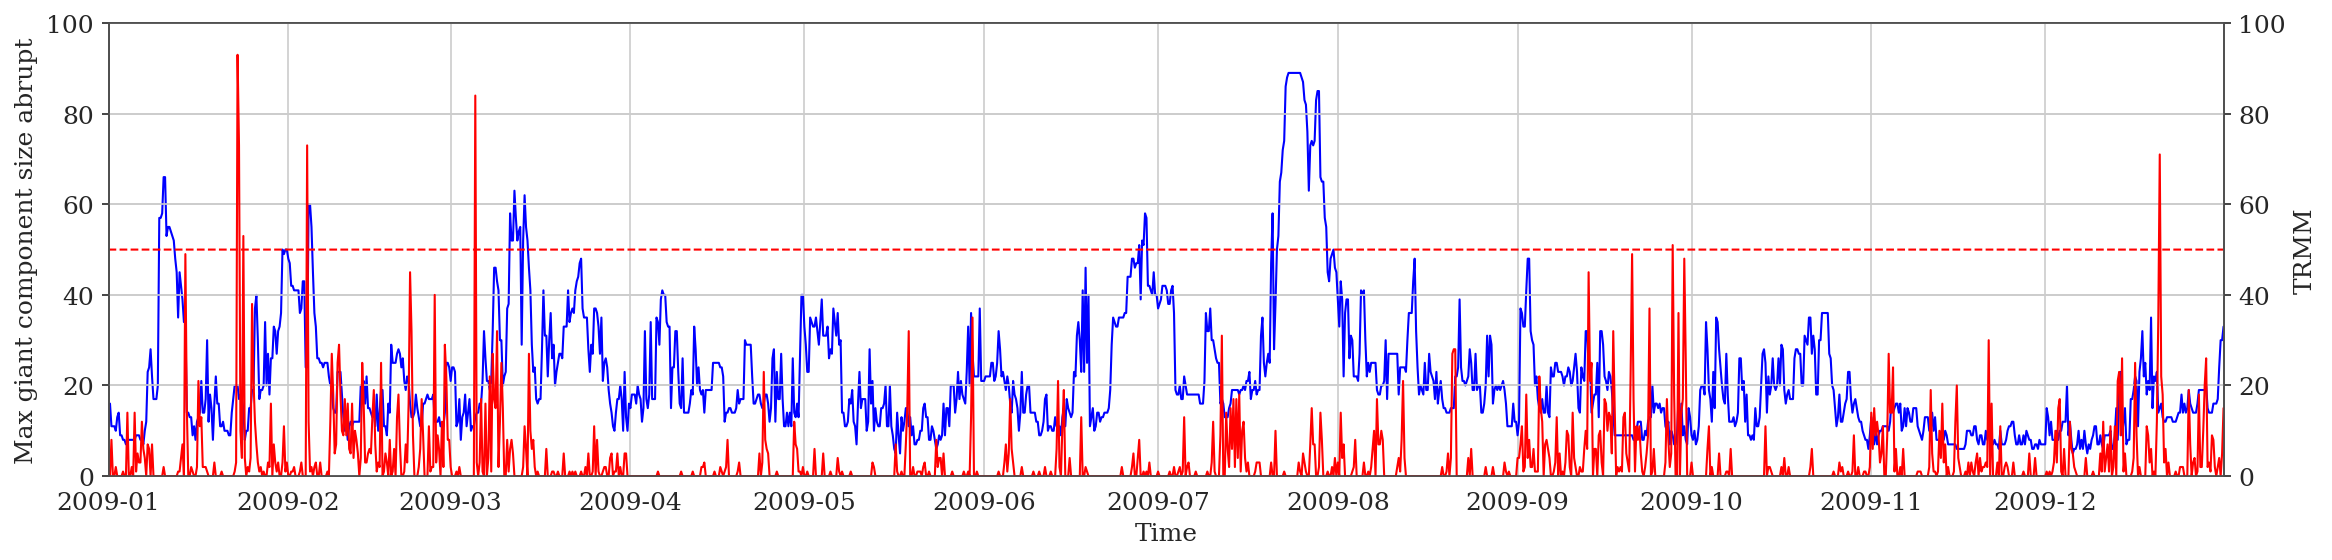

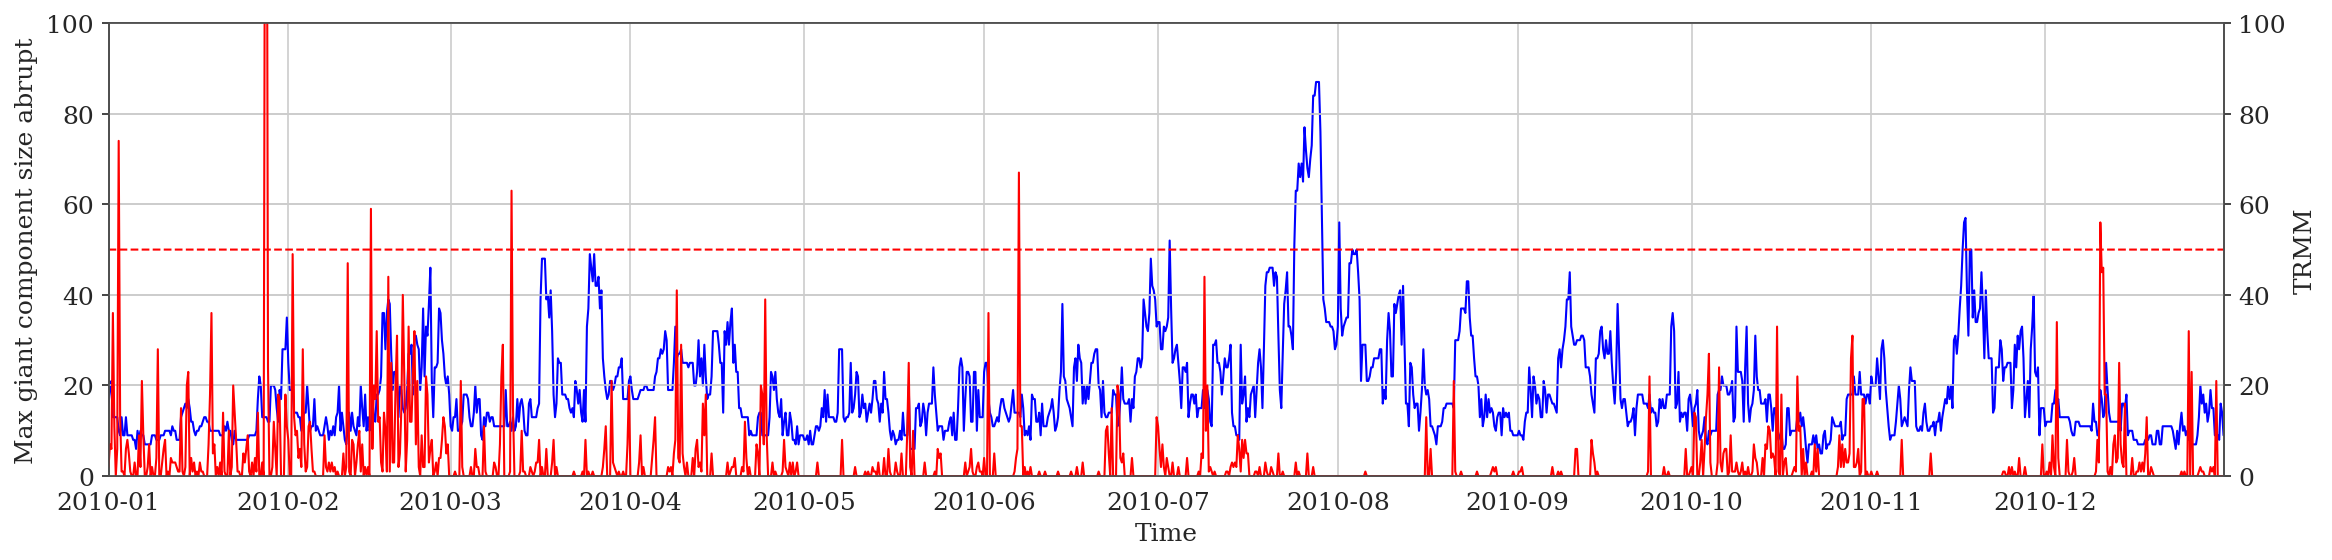

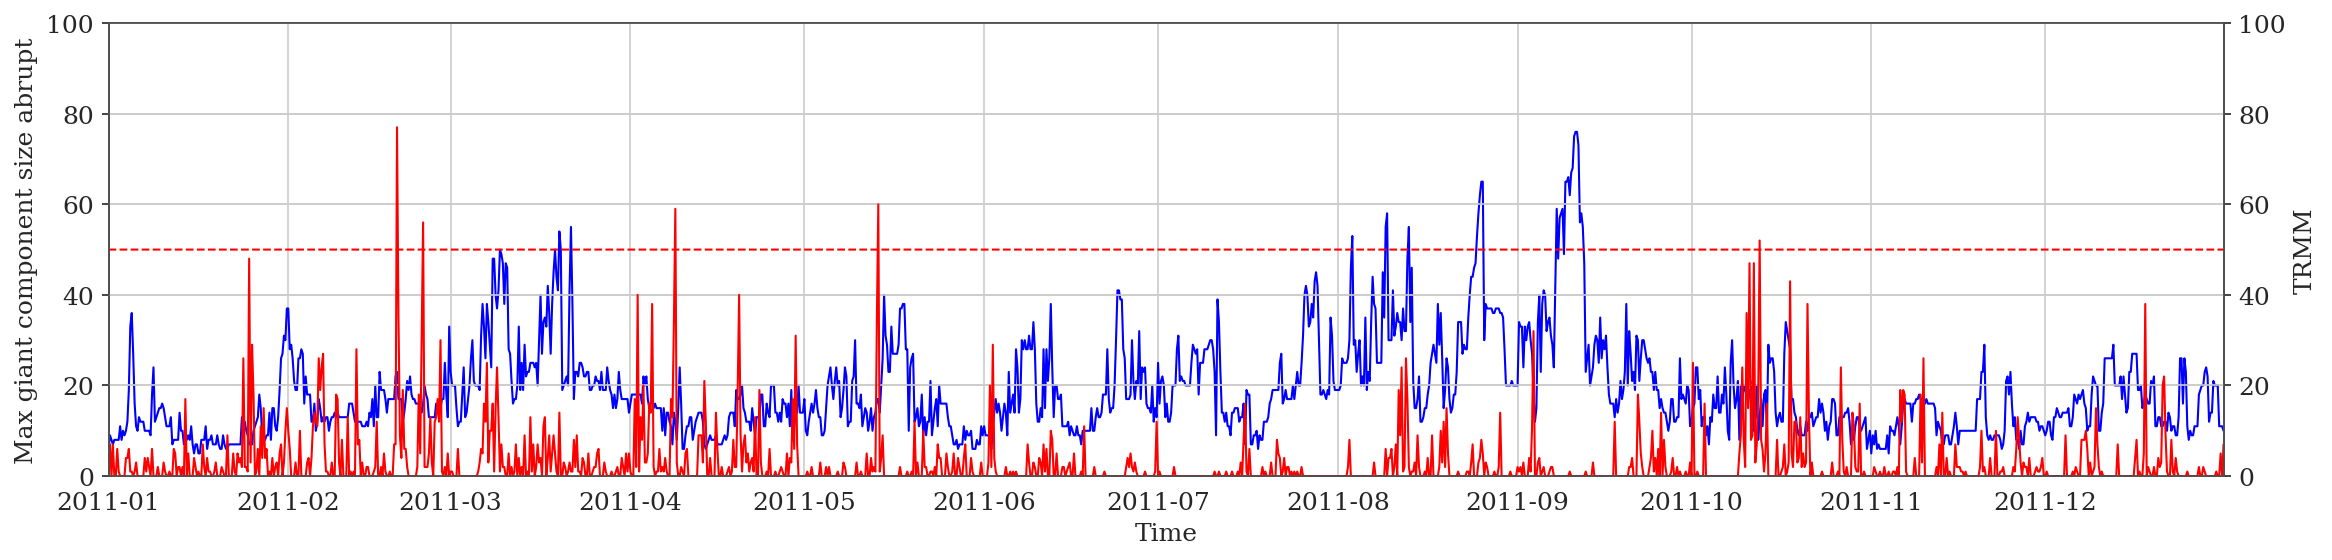

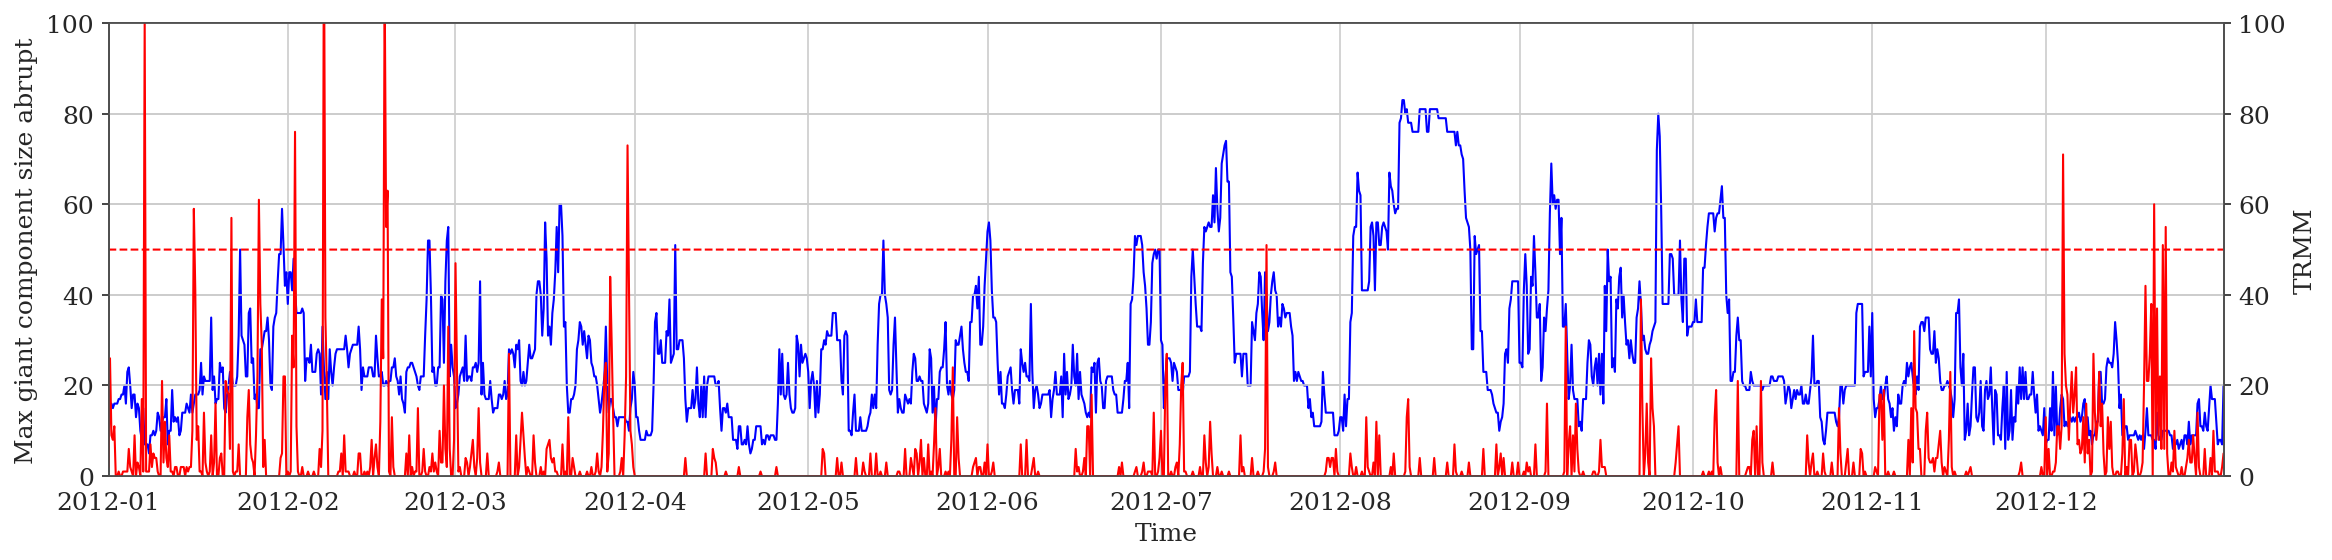

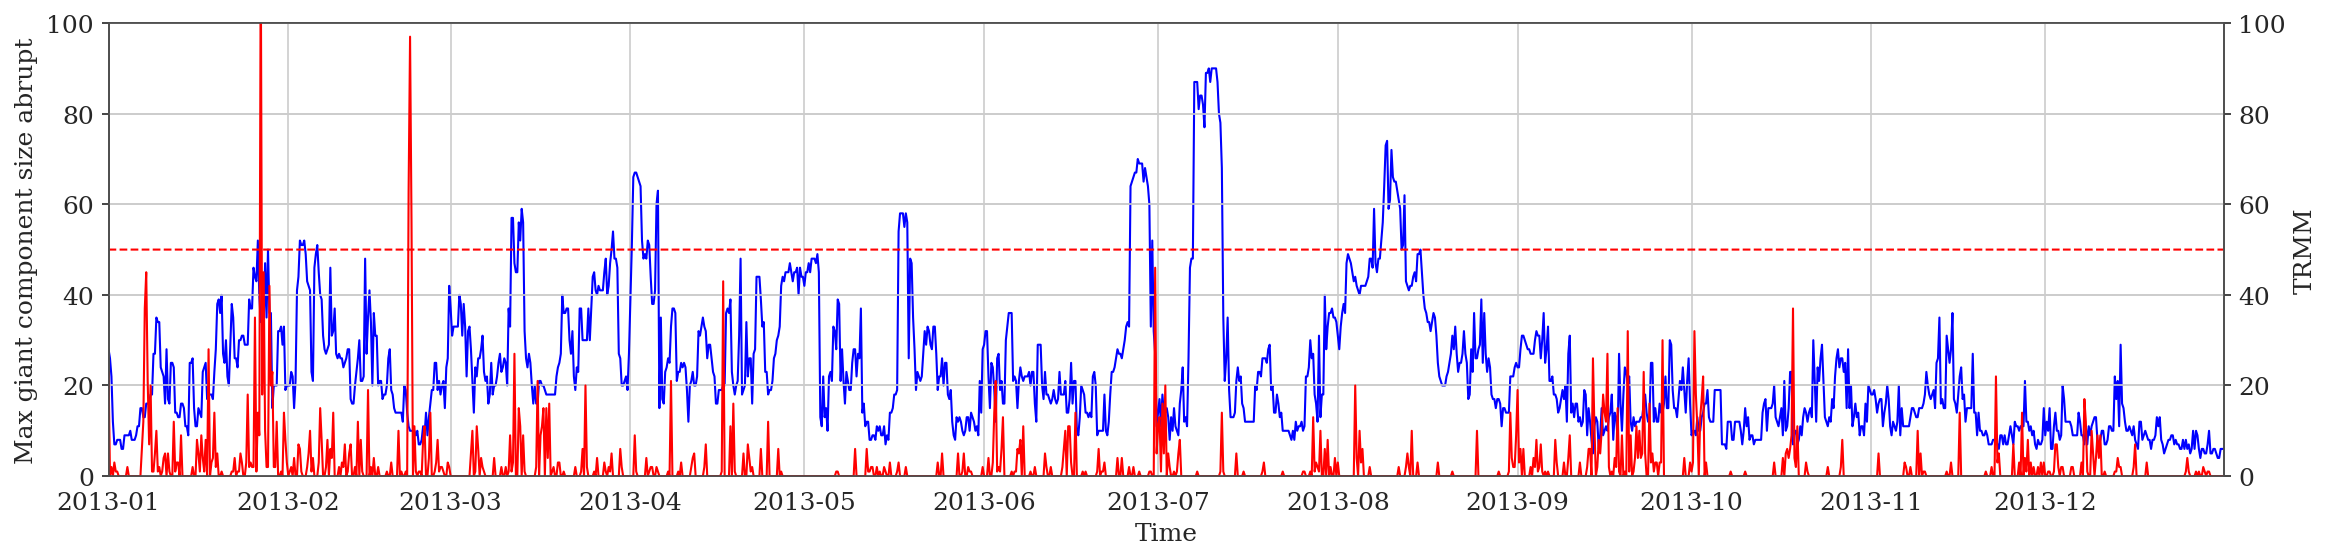

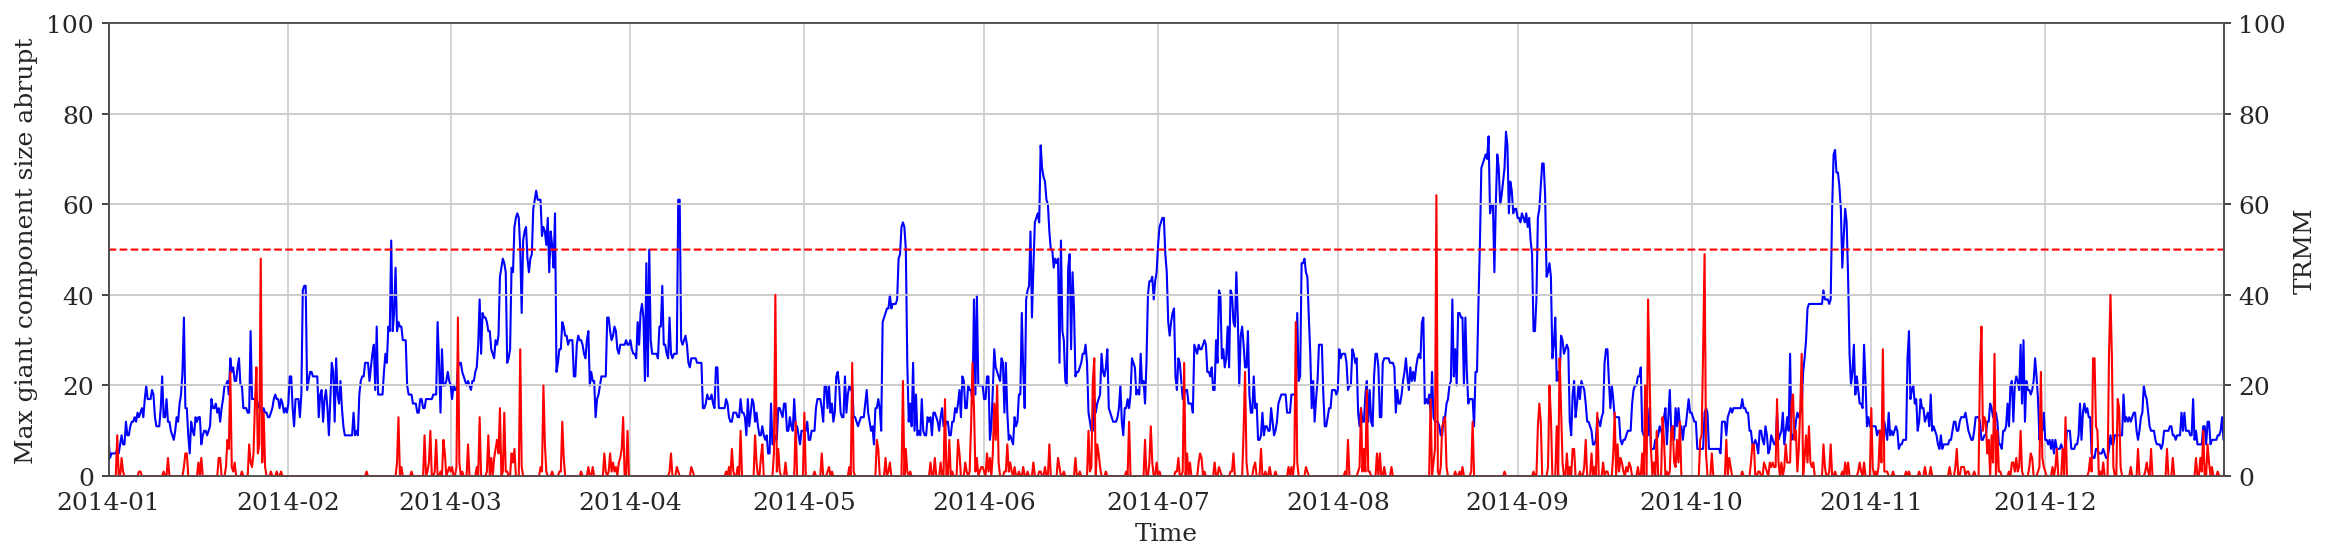

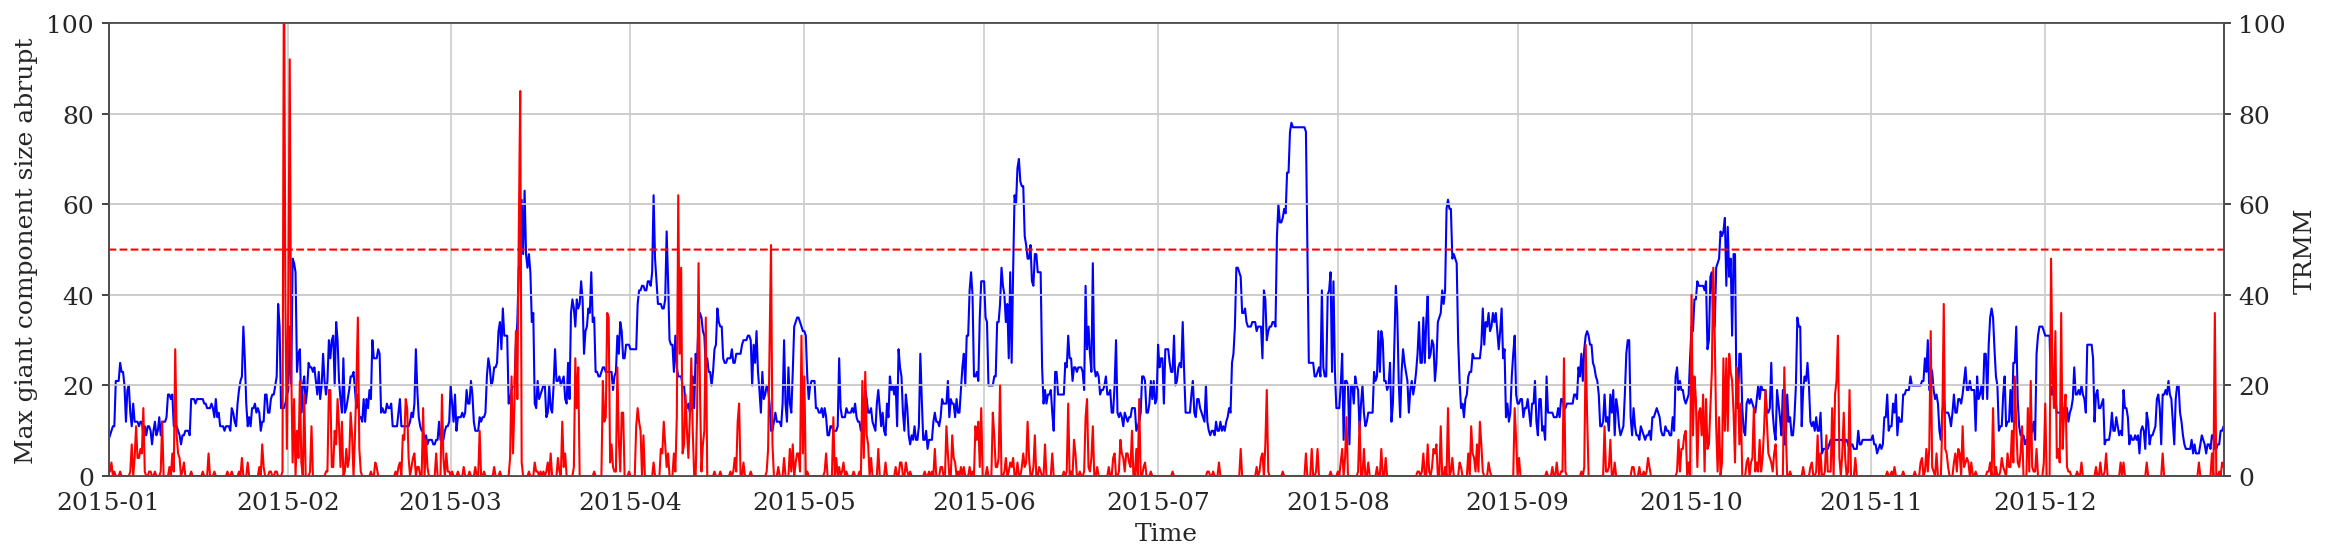

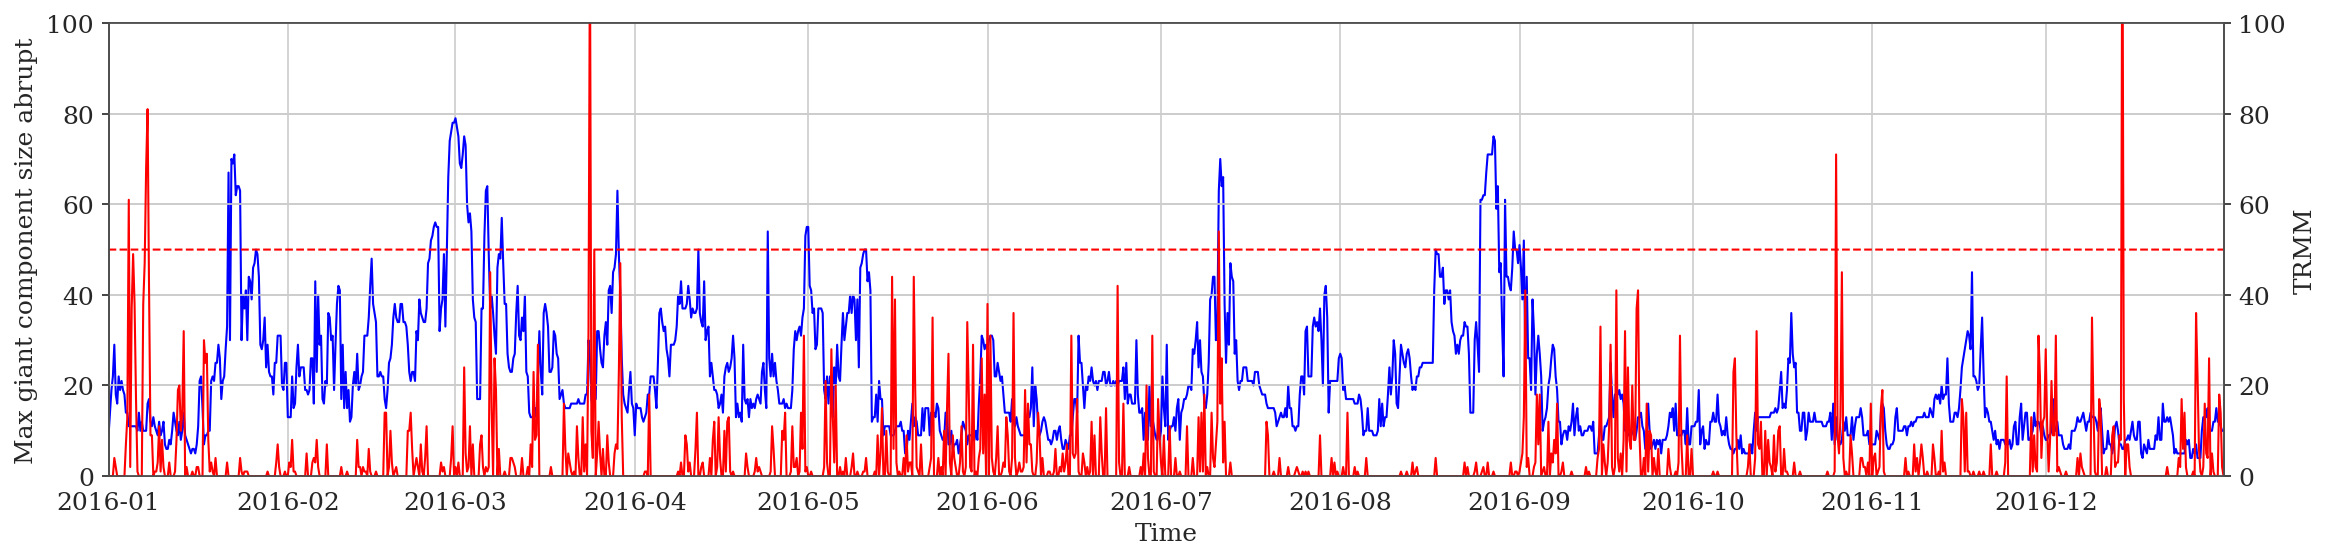

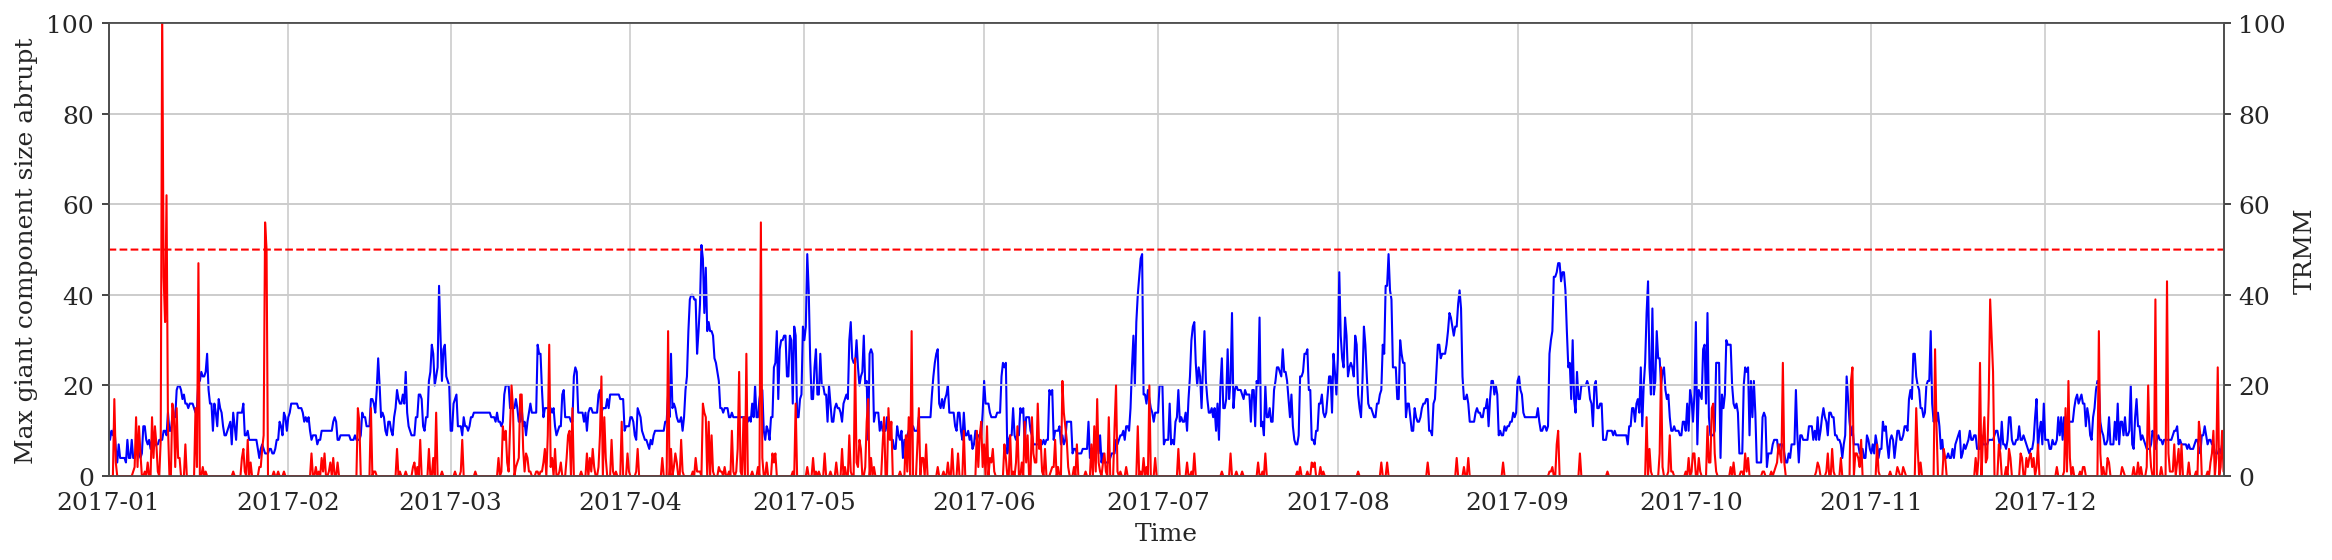

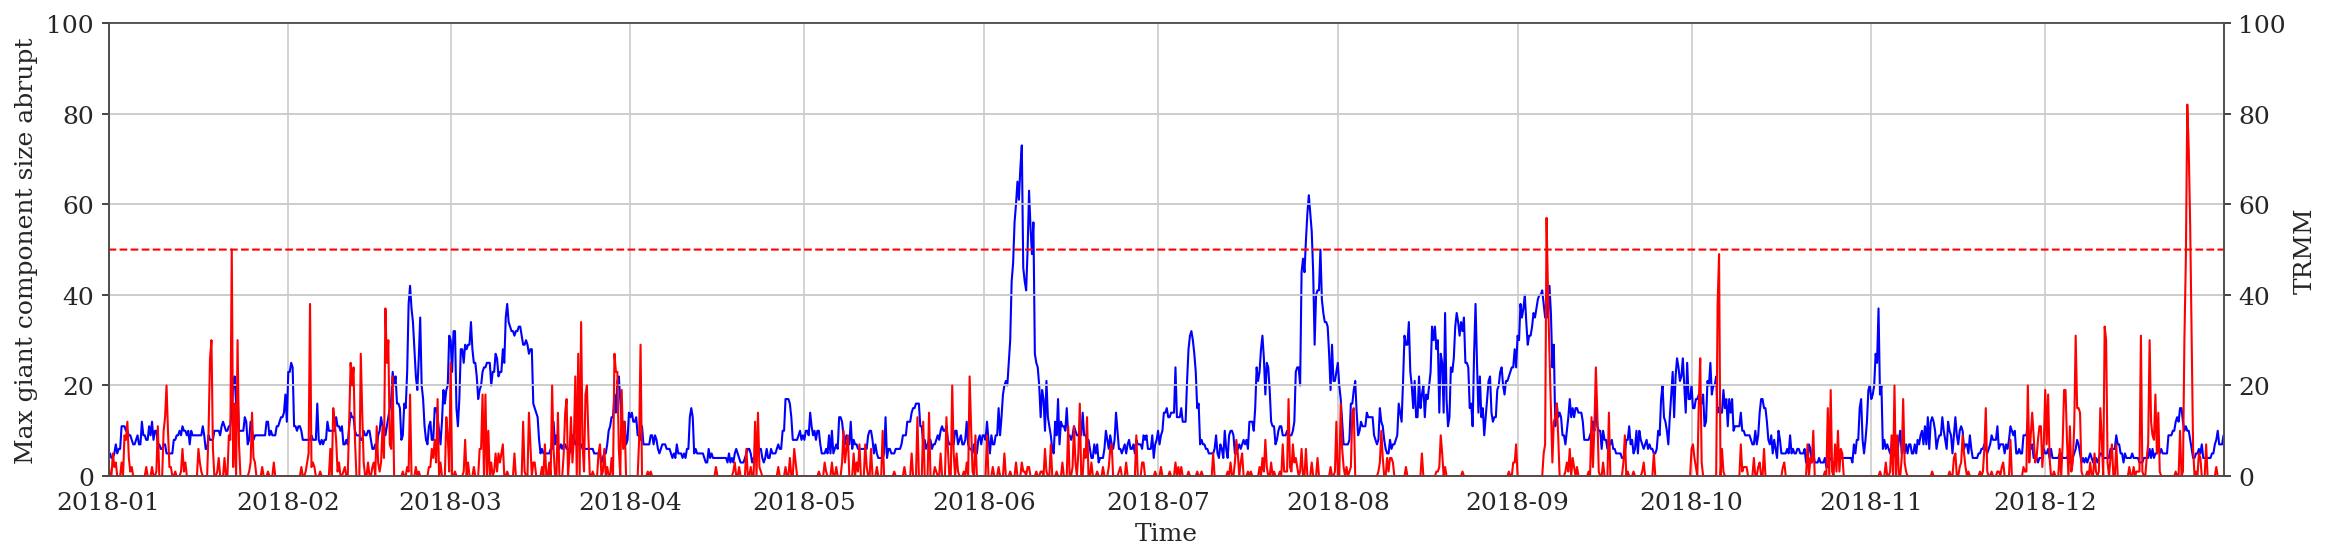

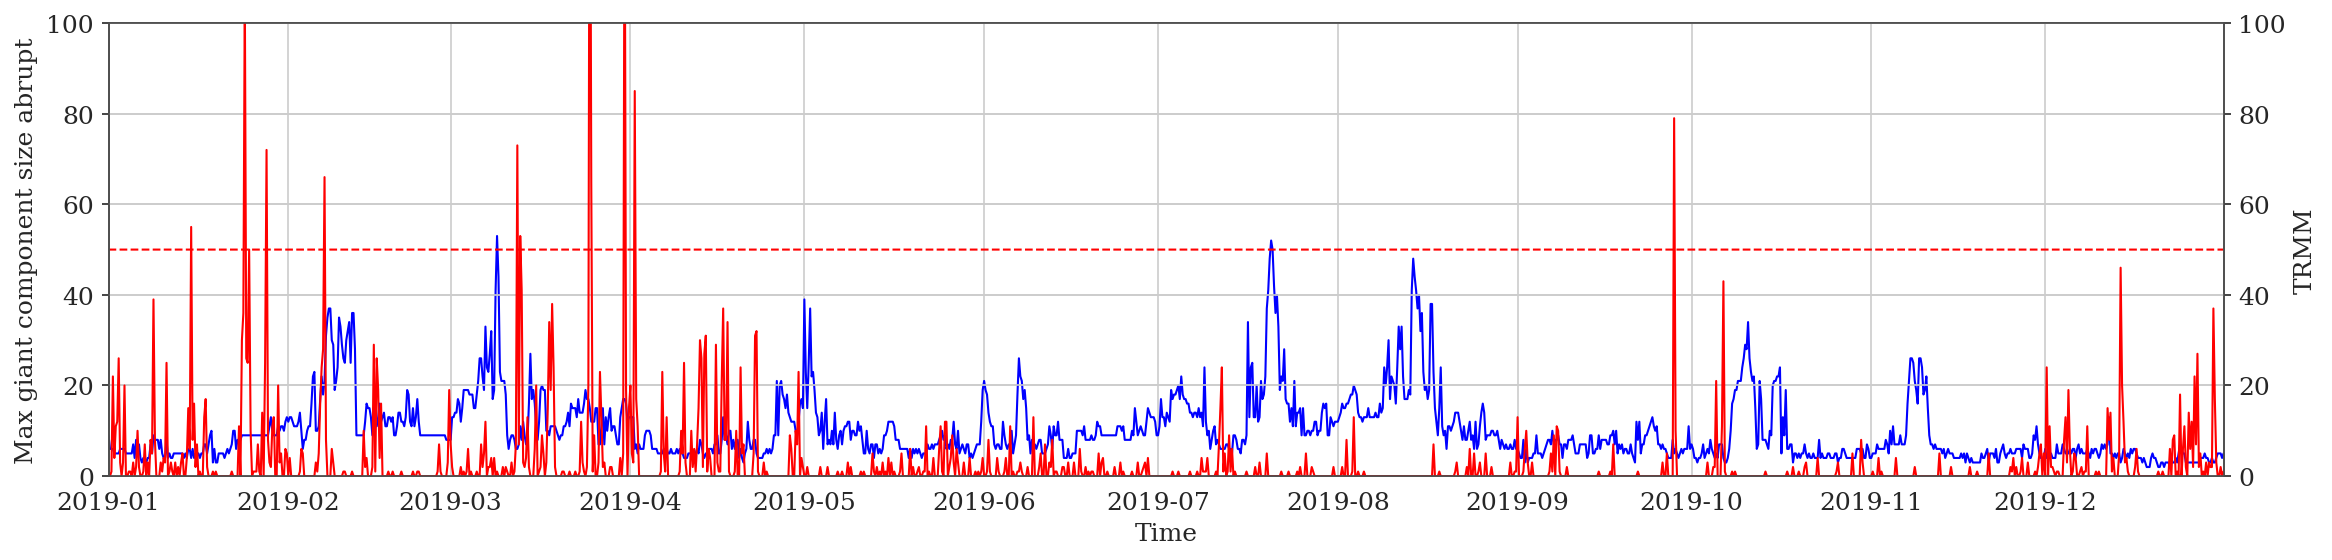

In [273]:

for year in range(1998, 2020):
    plt.figure(figsize = (15, 4), dpi = 150)
    ax1 = plt.gca()
    plot_delta_max(timeseries, delta_max_all, get_year_mask(timeseries, year))
    ax2 = ax1.twinx()
    plot_TRMM(timeseries_TRMM, TRMM_count, get_year_mask(timeseries_TRMM, year))
    plt.subplots_adjust(left = 0.03, right = 1 - 0.03)
    plt.savefig(result_dir / ('max_giant_abrupt_TRMM_year_' + str(year) + '.png'))
sdf
for year in range(1998, 2020):
    plt.figure(figsize = (15, 4), dpi = 150)
    ax1 = plt.gca()
    plot_delta_max(timeseries, delta_max_all, get_year_mask(timeseries, year))
    ax2 = ax1.twinx()
    plot_threshold(timeseries, delta_max_thr_all, get_year_mask(timeseries, year))
    plt.subplots_adjust(left = 0.03, right = 1 - 0.03)
    plt.savefig(result_dir / ('max_giant_abrupt_thr_year_' + str(year) + '.png'))

for year in range(1998, 2020):
    plt.figure(figsize = (15, 4), dpi = 150)
    ax1 = plt.gca()
    #plot_delta_max(timeseries, delta_max_all, get_year_mask(timeseries, year))
    plot_threshold(timeseries, delta_max_thr_all, get_year_mask(timeseries, year))
    ax2 = ax1.twinx()
    plot_TRMM(timeseries_TRMM, TRMM_count, get_year_mask(timeseries_TRMM, year))
    plt.subplots_adjust(left = 0.03, right = 1 - 0.03)
    plt.savefig(result_dir / ('max_giant_abrupt_thr_TRMM_year_' + str(year) + '.png'))
        

(array([383., 145.,  99.,  42.,  21.,  22.,   2.,   3.,   4.,   5.,   4.,
          3.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([2.77555756e-17, 5.71428571e-04, 1.14285714e-03, 1.71428571e-03,
        2.28571429e-03, 2.85714286e-03, 3.42857143e-03, 4.00000000e-03,
        4.57142857e-03, 5.14285714e-03, 5.71428571e-03, 6.28571429e-03,
        6.85714286e-03, 7.42857143e-03, 8.00000000e-03, 8.57142857e-03,
        9.14285714e-03, 9.7142

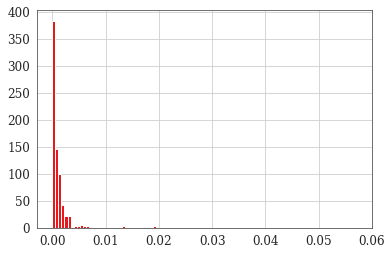

In [68]:
df = np.diff(np.sort(b[b > 0]))
plt.hist(df[df > 0], 100)


In [67]:
np.sort(b[b > 0])

array([0.17866199, 0.17866199, 0.18198045, ..., 1.        , 1.        ,
       1.        ])